# Event trigger investigation

In [1]:

# sessions = {
#     'P2': ['/imaging/camcan/cc700/CC700_MEG_Times.tsv', '/imaging/camcan/ccfrail/CCFrail_MEG_Times.tsv'], # Rest, Passive, SMT; Rest, Passive, SMT, MMN
#     'P3': ['/imaging/camcan/cc280/CC280_MEG_Times.tsv'], # Rest, Pic Name, Syn Task1, Syn Task2, Word Recog, MMN, Scene Rep, SNG1, SNG2
#     'P5': ['/imaging/camcan/ccrescan/CCrescan_MEG_Times.tsv'] # Rest, Passive, SMT, MMN, SNG, Movie, Story
# }

## Imports

In [2]:
import os
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from io import BytesIO
import base64
import sys
import contextlib
import logging
import io
from tqdm import tqdm
import re

## Misc functions

### get_original_events

In [3]:
def get_original_events(raw_file, consecutive='increasing', verbose=True):
  """
  Extract and count events from the raw MEG file.

  Parameters:
  -----------
  raw_file : str
    Path to the raw MEG file in FIF format.
  consecutive : bool|'increasing'
      The type of consecutive event detection to use based on MNE parameter for mne.find_events.
  verbose : bool, optional
        If True, prints event details. If False, suppresses printing. Default is True.

  Returns:
  --------
  events : numpy.ndarray
    Array containing the events detected in the raw MEG file.

  Example:
  --------
  >>> get_original_events(raw_file)
  Channel: STI001
    Event 5: 84 occurrences
  Channel: STI002
    Event 5: 80 occurrences
  Channel: STI003
    Event 5: 14 occurrences
  Channel: STI101
    Event 1: 38 occurrences
    Event 2: 40 occurrences
    Event 3: 40 occurrences
    Event 4: 4 occurrences
    Event 5: 4 occurrences
    Event 32768: 129 occurrences
    Event 32772: 6 occurrences
  """
  
  raw = mne.io.read_raw_fif(raw_file, preload=False, verbose=False)
  
  # Get the channels of interest
  event_channels = [channel for channel in raw.ch_names if channel in ['STI101'] + [f'STI{str(i).zfill(3)}' for i in range(1, 17)]]
  
  # for each channel, extract events
  for channel in event_channels: 
    
    # Extract events
    events = mne.find_events(raw, stim_channel=channel, min_duration=0.002, 
                            shortest_event=1, uint_cast=True, verbose=False, consecutive=consecutive)
    
    # if no events are found, skip to the next channel
    if len(events) == 0:
        continue
    
    if verbose:
      print(f"Channel: {channel}")      
      # Count events
      event_counts = mne.count_events(events, ids=None)
      
      # Display event counts for the subject
      for event, count in event_counts.items():
          print(f"    Event {event}: {count} occurrences")
        
  return events


### get_used_sti_channels

In [4]:
def get_used_sti_channels(raw_file):
  """
  Get the list of used STI channels from the raw MEG file.

  Parameters:
  -----------
  raw_file : str
    Path to the raw MEG file in FIF format.

  Returns:
  --------
  used_sti_channels : list of str
    List of STI channel names that are used (i.e., contain non-zero values).

  Example:
  --------
  >>> get_used_sti_channels(raw_file)
  ['STI001', 'STI002', 'STI003', 'STI101', 'STI201', 'STI301']
  """
  raw = mne.io.read_raw_fif(raw_file, preload=False, verbose=False)
  sti_channels = [channel for channel in raw.ch_names if channel.startswith('STI')]
  
  used_sti_channels = []
  for channel in sti_channels:
    data = raw.copy().pick([channel]).get_data()
    if np.any(data != 0):
      used_sti_channels.append(channel)
      
  return used_sti_channels

### print_unique_channel_values

In [5]:
def print_unique_channel_values(raw_file):
  """
  Get unique values for each STI channel in the raw MEG file.

  Parameters:
  -----------
  raw_file : str
    Path to the raw MEG file in FIF format.

  Returns:
  --------
  None
    Prints the unique values for each active STI channel.

  Example:
  --------
  >>> print_unique_channel_values(raw_file)
  Channel STI001 unique values: [0 5]
  Channel STI002 unique values: [0 5]
  Channel STI003 unique values: [0 5]
  Channel STI101 unique values: [-32768 -32764      0      1      2      3      4      5]
  Channel STI201 unique values: [   0  256  768 1792 3840 7936]
  Channel STI301 unique values: [-9 -8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8  9]
  """
  # Load MEG raw data
  raw = mne.io.read_raw_fif(raw_file, preload=False, verbose=False)

  # Get all available STI channels
  available_sti_channels = [ch for ch in raw.ch_names if ch.startswith('STI')]

  # Dictionary to store unique values for each channel
  sti_values = {}

  # Iterate over each STI channel
  for sti_channel in available_sti_channels:
      # Extract data for this channel
      sti_data = raw.get_data(picks=[sti_channel])[0].astype(int)
      
      # Get unique values in this channel
      unique_values = np.unique(sti_data)
      
      # Store values if any of them are nonzero
      if np.any(unique_values):
          sti_values[sti_channel] = unique_values

  # Print unique values for each channel
  for channel, values in sti_values.items():
      print(f"Channel {channel} unique values: {values}") 

### get_sti101_values

In [6]:
def get_sti101_values(raw_file=None, raw=None):
  """
  Get the unique values for STI101 channel in the raw MEG file.

  Parameters:
  -----------
  raw_file : str, optional
    Path to the raw MEG file in FIF format.
  raw : mne.io.Raw, optional
    Preloaded raw MEG data object.

  Returns:
  --------
  unique_values : numpy.ndarray
    Unique values for STI101 channel in the raw MEG file.

  Example:
  --------
  >>> get_sti101_values(raw_file='path/to/file.fif')
  array([-32768, -32764,      0,      1,      2,      3,      4,      5])
  >>> get_sti101_values(raw=raw)
  array([-32768, -32764,      0,      1,      2,      3,      4,      5])
  """
  if raw is None:
    if raw_file is None:
      raise ValueError("Either raw_file or raw must be provided.")
    raw = mne.io.read_raw_fif(raw_file, preload=False, verbose=False)

  # Extract data for STI101 channel
  sti101_data = raw.get_data(picks=['STI101'])[0].astype(int)
  
  # Get unique values in STI101 channel
  unique_values = np.unique(sti101_data)
  
  return unique_values

### decode_sti_value_full_info

In [7]:
def decode_sti_value_full_info(value):
  """
  Decode a signed 16-bit integer STI value to individual channel bits and labels.

  Parameters:
  -----------
  value : int
    Signed 16-bit integer representing the STI value.

  Returns:
  --------
  channels : list of str
    List of channel labels corresponding to the active bits in the STI value.
  bits : list of int
    List of power-of-2 values representing the active bits in the STI value.

  Example:
  --------
  >>> decode_sti_value_full_info(32769)
  (['STI001', 'STI016'], [1, 32768])
  """
  
  if value < 0:
      value = (1 << 16) + value  # Convert negative values to unsigned

  indices = [i for i in range(16) if value & (1 << i)]  # Get active bit indices
  bits = [1 << i for i in indices]  # Convert indices to power-of-2 values
  channels = [f"STI{str(i+1).zfill(3)}" for i in indices]  # Convert to STI labels

  return channels, bits

### decode_sti_value

In [8]:
def decode_sti_value(value):
  """
  Decode a signed 16-bit integer STI value to a combination of summed small bits and individual large bits.

  Parameters:
  -----------
  value : int
    Signed 16-bit integer representing the STI value.

  Returns:
  --------
  decoded_sti_value : int or list of int
    If the value contains only small bits (< 256), returns their sum.
    If the value contains only large bits (>= 256), returns a list of those bits.
    If the value contains both, returns a list with the sum of small bits followed by the large bits.

  Example:
  --------
  >>> decode_sti_value(32772)
  [4, 32768]
  >>> decode_sti_value(32773)
  [5, 32768]
  >>> decode_sti_value(3)
  3
  """
  if value < 0:
      value = (1 << 16) + value  # Convert negative values to unsigned

  indices = [i for i in range(16) if value & (1 << i)]  # Get active bit indices
  bits = [1 << i for i in indices]  # Convert indices to power-of-2 values

  # Separate bits into two groups: those < 256 and those >= 256
  small_bits = [b for b in bits if b < 256]  # Values to be summed
  large_bits = [b for b in bits if b >= 256]  # Keep as separate elements

  # Sum small values and combine with larger values
  if small_bits:
      summed_value = sum(small_bits)  # Sum bits < 256
      return [summed_value] + large_bits if large_bits else summed_value
  decoded_sti_value = large_bits if len(large_bits) > 1 else large_bits[0]  # Single large values remain as is
  
  return decoded_sti_value

### print_decoded_sti101_channel

In [9]:
def print_decoded_sti101_channel(raw_file, consecutive='increasing'):
    """
    Decode STI101 channel from a raw MEG file.

    Parameters:
    -----------
    raw_file : str
      Path to the raw MEG file in FIF format.
    consecutive : bool|'increasing'
      The type of consecutive event detection to use based on MNE parameter for mne.find_events.

    Returns:
    --------
    None
      Prints the decoded STI101 events and their counts.

    Example:
    --------
    >>> print_decoded_sti101_channel('sample_raw.fif')
    STI101 events:  [1, 2, 3, 4, 5, 32768, 32772]
    Decoded events: [1, 2, 3, 4, 5, 32768, [4, 32768]]
        Event 1: 38 occurrences
        Event 2: 40 occurrences
        Event 3: 40 occurrences
        Event 4: 4 occurrences
        Event 5: 4 occurrences
        Event 32768: 129 occurrences
        Event 32772: 6 occurrences
    """
    raw = mne.io.read_raw_fif(raw_file, preload=False, verbose=False)
    
    events = mne.find_events(raw, stim_channel='STI101', min_duration=0.002, shortest_event=1, uint_cast=True, verbose=False, consecutive=consecutive)
    
    if len(events) == 0:
        print("No events found.")
        return
    
    event_counts = mne.count_events(events, ids=None)
    sti101_values = list(event_counts.keys())

    # Decode STI101 values
    decoded_values = [decode_sti_value(val) for val in sti101_values]

    print(f"STI101 events:  {sti101_values}")
    print(f"Decoded events: {decoded_values}")
          # Display event counts for the subject
    for event, count in event_counts.items():
        print(f"    Event {event}: {count} occurrences")

### split_sti101

In [10]:
def split_sti101(raw_file=None, data=None, times=None):
  """
  Decompose the STI101 channel into individual time series for each unique value.

  Parameters:
  -----------
  raw_file : str, optional
    Path to the raw MEG file in FIF format.
  data : numpy.ndarray, optional
    Preloaded data array containing the STI101 channel time series.
  times : numpy.ndarray, optional
    Preloaded array containing the time points corresponding to the data samples.

  Returns:
  --------
  data101 : numpy.ndarray
    Array containing the time series for each unique value in the STI101 channel.
  times : numpy.ndarray
    Array containing the time points corresponding to the data samples.
  sti_channels : list of str
    List of channel names corresponding to the columns in the data101 array.

  Example:
  --------
  >>> data101, times, sti_channels = split_sti101('sample_raw.fif')
  Unique values found: [1, 2, 3, 4, 5, 32768, 32772]
  Decoded channels: ['STI001', 'STI002', 'STI003', 'STI004', 'STI005', 'STI016', 'STI004 STI016']
  """
  if raw_file is not None:
    raw = mne.io.read_raw_fif(raw_file, preload=False, verbose=False)
    data, times = raw.get_data(picks='STI101', return_times=True)
  elif data is None or times is None:
    raise ValueError("Either raw_file or both data and times must be provided.")

  # Extract unique values that are greater than 0
  unique_values = np.unique(data)
  unique_values = unique_values[unique_values != 0].astype(int).tolist()
  print(f"Unique values found: {unique_values}")

  # Decode values to the original channels
  decoded = {val: decode_sti_value_full_info(val) for val in unique_values}
  sti_channels = [' '.join(channels) for val, (channels, bits) in decoded.items()]

  print(f"Decoded channels: {sti_channels}")

  # Create a time-series per each unique value
  data101 = np.zeros((len(times), len(unique_values)))
  for i, val in enumerate(unique_values):
    temp = data.copy()
    temp[temp != val] = 0  # Set all other values to 0
    temp[temp == val] = 1.5  # Set the selected value to 5
    data101[:, i] = temp  # Assign to the correct column

  return data101, times, sti_channels

### get_channel_timecourses

In [11]:
def get_channel_timecourses(raw_file):
  """
  Extract and decode STI channel time courses from raw MEG data.
  Combines the original STI channels (STI001 to STI016) with additional channels decoded from STI101.
  The function returns the combined time courses, time points, and channel names.
  
  # Uses a function: decode_sti_value_full_info

  Parameters:
  -----------
  raw_file : str
    Path to the raw MEG data file.

  Returns:
  --------
  data : numpy.ndarray (n_samples, n_channels)
    Combined time courses of the original STI channels and additional ones decoded from STI101.
  times : numpy.ndarray (n_samples,)
    Time points corresponding to the data samples.
  channel_lables : list
    List of channel names corresponding to the columns in the data array.
  """
  # Load raw data
  raw = mne.io.read_raw_fif(raw_file, preload=False, verbose=False)
  
  print("\nGetting active channel timecourses...")

  # -----------------------------------------------------------------------------------------------
  # Get the original STI001 to STI016 channels
  # -----------------------------------------------------------------------------------------------
  original_channels = [channel for channel in raw.ch_names if channel in [f'STI{str(i).zfill(3)}' for i in range(1, 17)]]
  print(f"Original channels: {original_channels}")
  data_original = raw.get_data(picks=original_channels)

  # Identify which channels have at least one nonzero value
  active_channels = np.any(data_original, axis=1)

  # Get the corresponding channel names
  kept_original_channels = [name for name, keep in zip(original_channels, active_channels) if keep]
  removed_channels = [name for name, keep in zip(original_channels, active_channels) if not keep]

  # Filter out the inactive channels
  data_original = data_original[active_channels,:]
  
  # replace all non-zero values with 1
  data_original[data_original != 0] = 1.5 # default is 5

  print(f"Kept active Channels: {kept_original_channels}")
  print(f"Removed Channels: {removed_channels}")

  # -----------------------------------------------------------------------------------------------
  # Get the STI101 channel and decode each unique value to the original channels
  # -----------------------------------------------------------------------------------------------
  raw_sti101 = raw.copy().pick('STI101')
  data_101, times = raw_sti101.get_data(return_times=True) 

  # Extract unique values that are greater than 0
  unique_values = np.unique(data_101)
  unique_values = unique_values[unique_values != 0].astype(int).tolist()
  print(f"Unique values in STI101: {unique_values}")

  # Decode STI101 values to the original channels
  decoded = {val: decode_sti_value_full_info(val) for val in unique_values}
  sti101_channels = [' '.join(channels) for val, (channels, bits) in decoded.items()]

  print(f"Decoded STI101 values: {sti101_channels}")

  # Keep only the channels that are not in the original set
  mask = np.array([name not in kept_original_channels for name in sti101_channels])
  filtered_unique_values = np.array(unique_values)[mask].tolist()
  kept_sti101_channels = np.array(sti101_channels)[mask].tolist()
  
  print(f"Kept STI101 Channels: {kept_sti101_channels}")

  # # Create a time-series per each unique value in the filtered STI101
  data101 = np.zeros((len(times), len(filtered_unique_values)))
  for i, val in enumerate(filtered_unique_values):
      temp = data_101.copy()
      temp[temp != val] = 0  # Set all other values to 0
      temp[temp == val] = 1.5  # Set the selected value to 5
      data101[:, i] = temp  # Assign to the correct column

  # -----------------------------------------------------------------------------------------------

  # merge data and data_original
  data = np.concatenate((data101, data_original.T), axis=1)

  # and merge sti101_channels with original_channels
  channel_lables = kept_sti101_channels + kept_original_channels
  
  print(f"Final channel labels: {channel_lables}")
  
  return data, times, channel_lables

### create_event_onsets_version1

This was just decomposing STI101 to disentagle events that overlaped with button presses. 

In [12]:
def create_event_onsets_version1(time_series_array, channel_names, raw, verbose=True):
    """
    Create corrected events from the decomposed STI101 channel time-series.

    This function should be used together with the decompose_sti101_in_individual_channels function.

    Parameters:
    -----------
    time_series_array : numpy.ndarray
      Array containing the time series for each individual channel.
    channel_names : list of str
      List of individual channel names.
    verbose : bool, optional
        If True, prints event details. If False, suppresses printing. Default is True.

    Returns:
    --------
    events : numpy.ndarray
      Array containing the corrected events.
    event_counts : dict
      Dictionary containing the count of each event.

    Example:
    --------
    >>> time_series_array, channel_names = decompose_sti101_in_individual_channels('sample_raw.fif')
    >>> events, event_counts = create_event_onsets(time_series_array, channel_names)
    """
    num_samples = time_series_array.shape[0]
    stim_channels = [f'STI{str(i).zfill(3)}' for i in range(1, 9)]
    response_channels = [f'STI{str(i).zfill(3)}' for i in range(9, 17)]

    # from time_series_array extract the columns that belong to stim_channels
    stim_indices = [channel_names.index(ch) for ch in stim_channels if ch in channel_names] 
    stim_data = time_series_array[:, stim_indices]

    # from time_series_array extract the columns that belong to response_channels
    resp_indices = [channel_names.index(ch) for ch in response_channels if ch in channel_names]
    resp_channel_names = [f'new{channel_names[i]}' for i in resp_indices]
    resp_data = time_series_array[:, resp_indices]

    sti101_new = np.sum(stim_data.T, axis=0, keepdims=True)

    event_data = np.concatenate([sti101_new, resp_data.T], axis=0)

    # Create dummy info and raw object to use find_events
    ch_names = ['newSTI101'] + resp_channel_names
    info = mne.create_info(ch_names, raw.info['sfreq'], 'stim')

    raw_temp = mne.io.RawArray(event_data, info, first_samp=raw.first_samp, verbose="WARNING")
    
    events = mne.find_events(
      raw_temp, 
      stim_channel=ch_names, 
      min_duration=0.002, 
      consecutive='increasing', 
      uint_cast=True, 
      verbose='WARNING')  

    event_counts = mne.count_events(events, ids=None)

    if verbose:
      print("\nEvent Counts")
      for event, count in event_counts.items():
        print(f"    Event {event}: {count} occurrences")  

    return events, event_counts

### Rik's correction. get_corrected_event_onsets

In [13]:
# Rik's correction

def get_corrected_event_onsets(raw_file, channel='STI101', verbose=True):
  """
  This function corrects the event onsets in the STI101 channel of a raw MEG file.
  It identifies the upward jumps in the signal and records the onset time and the value of the jump.

  Parameters:
  -----------
  raw_file : str
    Path to the raw MEG file in FIF format.
  channel : str
    The name of the channel to be corrected. Default is 'STI101'.
  verbose : bool, optional
        If True, prints event details. If False, suppresses printing. Default is True.

  Returns:
  --------
  corrected_event_onsets : numpy.ndarray
    Array containing the corrected event onsets. Each row contains the onset time and the value of the jump.

  Example:
  --------
  >>> corrected_event_onsets = get_corrected_event_onsets('sample_raw.fif', channel='STI101')
  Channel: STI101
    Event 1: 38 occurrences
    Event 2: 40 occurrences
    Event 3: 40 occurrences
    Event 4: 4 occurrences
    Event 5: 4 occurrences
    Event 32768: 129 occurrences
    Event 32772: 6 occurrences
  """
  
  raw = mne.io.read_raw_fif(raw_file, preload=False, verbose=False)
  data, times = raw.get_data(picks=channel, return_times=True)
  
  channel_signal = np.abs(data[0]) 
  signal_length = len(channel_signal)
  
  corrected_event_onsets = []
  
  for t in range(signal_length-2):
    
    diff = channel_signal[t+1] - channel_signal[t] # np.diff(channel_signal)
    
    if diff > 0 and (channel_signal[t+2] == channel_signal[t+1]): # if  signal has an upward jump and stays the same for the next sample
      onset = times[t+1] * raw.info['sfreq'] + raw.first_samp
      event = diff
      corrected_event_onsets.append([onset, event]) # onset of the upward jump and the value of the jump

  corrected_event_onsets = np.array(corrected_event_onsets)
  
  if verbose:
    print(f"Channel: {channel}")         
    for i in np.unique(corrected_event_onsets[:, 1]):
      print(f"  Event {int(i)}: {sum(corrected_event_onsets[:, 1] == i)} occurrences")
  
  return corrected_event_onsets.astype(int)

  # data = np.abs(data[0]) 
  # codes = []
  # onsets = []
  # for t in range(len(data)-2):
  #     d = data[t+1]-data[t]
  #     if d > 0 and (data[t+2] == data[t+1]):
  #         codes.append(d)
  #         onsets.append(times[t+1])


## Plotting functions

### create_basic_plot

In [14]:
def create_basic_plot(data, times, channel_labels, show_channels=None, title="STI Channels Time Course"):
    """
    Create a basic plot of the STI channel time courses.
    
    Parameters:
    -----------
    data : numpy.ndarray (n_channels, n_samples)
        Time courses of the STI channels.
    times : numpy.ndarray (n_samples,)
        Time points corresponding to the data samples.
    channel_labels : list
        List of channel names corresponding to the columns in the data array.
    show_channels : list or None
        List of channel names to display. If None, all channels are displayed.
        
    Returns:
    --------
    plt : matplotlib.pyplot object
        Matplotlib plot object.
    """
    
    data = (data != 0).astype(int)  # Convert to binary values

    # Ensure data is in (n_samples, n_channels) shape
    if data.shape[0] < data.shape[1]:  # If channels are rows and samples are columns, transpose it
        data = data.T  # Convert to (n_samples, n_channels)
    
    if show_channels is not None:
        # Find indices of selected channels in the original list
        selected_indices = [i for i, ch in enumerate(channel_labels) if ch in show_channels]
        
        # Use these indices to filter both channel names and data
        channel_labels = [channel_labels[i] for i in selected_indices]
        data = data[:, selected_indices] if data.ndim > 1 else data[selected_indices].reshape(-1, 1)

    # Ensure data is always 2D
    if data.ndim == 1:
        data = data.reshape(-1, 1)

    num_channels = data.shape[1]  # Get the actual number of channels after filtering

    # Define vertical offset for spacing
    offset_step = 2  # Adjust for more or less spacing
    y_offsets = np.arange(0, len(channel_labels) * offset_step, offset_step)

    # Get the default Matplotlib color cycle
    default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    channel_colors = {ch: default_colors[i % len(default_colors)] for i, ch in enumerate(channel_labels)}

    # Plot each active STI channel with offset
    for i, (channel, offset) in enumerate(zip(channel_labels, y_offsets)):
        plt.plot(times, data[:, i] + offset, label=channel, color=channel_colors[channel], alpha=0.7)

    # Set custom y-ticks and labels
    plt.yticks(y_offsets, channel_labels)

    plt.xlabel("Time (s)")
    # plt.ylabel("STI Channels")
    plt.title(title)

    return plt

### create_interactive_plot

In [15]:
def create_interactive_plot(data, times, channel_lables, show_channels=None, downsampling_factor=None, title="STI Channels Time Course", hovermode="x unified"):
    """
    Create an interactive plot of the STI channel time courses using Plotly.

    Parameters:
    -----------
    data : numpy.ndarray (n_samples, n_channels)
        Time courses of the STI channels.
    times : numpy.ndarray (n_samples,)
        Time points corresponding to the data samples.
    channel_lables : list
        List of channel names corresponding to the columns in the data array.
    show_channels : list or None
        List of channel names to display. If None, all channels are displayed.
    downsampling_factor : int or None
        Downsampling factor to reduce the number of time points. If None, no downsampling is applied.
    title : str
        Title of the plot.
    hovermode : str pr False
        Hover mode for the plotly figure

    Returns:
    --------
    fig : plotly.graph_objects.Figure object
        Plotly figure object.
    """

    data = (data != 0).astype(int)  # Convert to binary values
    
    if show_channels is not None:
        # Find indices of selected channels in the original list
        selected_indices = [i for i, ch in enumerate(
            channel_lables) if ch in show_channels]

        # Use these indices to filter both channel names and data
        channel_lables = [channel_lables[i] for i in selected_indices]
        data = data[:, selected_indices]

    if downsampling_factor is not None:
        times = times[::downsampling_factor]
        data = data[::downsampling_factor, :]

    
    # Reverse the order to match the y-axis in the plot
    channel_lables = channel_lables[::-1]
    data = data[:, ::-1]  # Reverse data to match the new order

    # Define vertical offset for spacing (Reverse order)
    offset_step = 2
    y_offsets = np.arange(0, len(channel_lables) * offset_step, offset_step)[::-1]
    
    # Get the default Matplotlib color cycle
    default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    channel_colors = {ch: default_colors[i % len(
        default_colors)] for i, ch in enumerate(channel_lables)}

    fig = go.Figure()

    # Add each STI channel as a separate trace
    for i, (channel, offset) in enumerate(zip(channel_lables, y_offsets)):
      hover_values = np.where(data[:, i] != 0, f"{channel} ON", "")  # Show '1' only if active, otherwise empty
      
      fig.add_trace(go.Scatter(
          x=times,
          y=data[:, i] + offset,  # Apply vertical offset
          mode='lines',
          name=channel,
          line=dict(color=channel_colors[channel], width=1),
          # hovertemplate="%{y}" + "%{y:.1f}" + "<extra></extra>",  # Show None when y=0
          # hovertemplate="%{y}" + "<extra></extra>", 
          hovertemplate="%{customdata}<extra></extra>", 
          customdata=hover_values, 
          showlegend=False 
      ))

    # Customize layout
    fig.update_layout(
        title=title,
        xaxis_title="Time (s)",
        yaxis_title="STI Channels",
        yaxis=dict(
            tickmode="array",
            tickvals=y_offsets,
            ticktext=channel_lables  # Label each channel at the offset
        ),
        template="plotly_white",
        hovermode=hovermode,  # "x unified",
        # hoverlabel=dict(namelength=0),  # Hide hover label names
    )
    
    return fig

## Cleaning Functions

These functions are needed to get the corrected events and create the reports of corrections. 

The main issue seems to be that sometimes STI003 gets triggered alongside STI015 or STI016 creating unwanted, and often long, STI003 activations. 


### decompose_sti101_in_individual_channels

In [16]:
def decompose_sti101_in_individual_channels(raw_file=None, data=None, times=None, raw=None, verbose=True):
  """
  Decompose the STI101 channel into individual channels and create a time-series matrix.

  Parameters:
  -----------
  raw_file : str, optional
    Path to the raw MEG file in FIF format.
  data : numpy.ndarray, optional
    Preloaded data array containing the STI101 channel time series.
  times : numpy.ndarray, optional
    Preloaded array containing the time points corresponding to the data samples.
  raw : mne.io.Raw, optional
    Raw MEG data object.
  verbose : bool, optional
    If True, prints the unique values and individual channels. If False, suppresses printing. Default is True.

  Returns:
  --------
  time_series_array : numpy.ndarray
    Array containing the time series for each individual channel.
  channel_names : list of str
    List of individual channel names.
  raw : mne.io.Raw
    Raw MEG object containing metadata like sampling frequency.

  Example:
  --------
  >>> time_series_array, channel_names = decompose_sti101_in_individual_channels('sample_raw.fif')
  Unique values found: [1, 2, 3, 4, 5, 4096]
  Individual channels: ['STI001', 'STI002', 'STI003', 'STI013', 'STI016']
  """
  # Load raw STI101 data
  if raw is None:
    if raw_file is not None:
      raw = mne.io.read_raw_fif(raw_file, preload=False, verbose="WARNING")
      data, times = raw.get_data(picks="STI101", return_times=True)
    elif data is None or times is None:
      raise ValueError("Either raw_file or both data and times must be provided.")
  else:
    data, times = raw.get_data(picks="STI101", return_times=True)

  # Extract unique STI values (ignoring 0)
  unique_values = np.unique(data[data != 0]).astype(int)
  if unique_values.size == 0 and verbose:
    print("No events detected in STI101.")
    return np.empty((0, 0), dtype=int), [], raw

  # Decode values into individual STI channels
  decoded = {val: decode_sti_value_full_info(val) for val in unique_values}
  individual_channels = sorted({ch for val, (channels, _) in decoded.items() for ch in channels})
  
  if verbose:
    print(f"Unique values found: {unique_values.tolist()}; Individual channels: {individual_channels}")

  # Precompute channel indices for fast access
  channel_indices = {ch: idx for idx, ch in enumerate(individual_channels)}

  # Initialize the time-series matrix
  num_samples, num_channels = len(times), len(individual_channels)
  time_series_array = np.zeros((num_samples, num_channels), dtype=int)

  # Fill in the matrix efficiently
  for t in range(num_samples):
    current_value = int(data[0, t])
    if current_value != 0:
      channels, bits = decode_sti_value_full_info(current_value)
      for ch, bit in zip(channels, bits):
        time_series_array[t, channel_indices[ch]] = bit

  return time_series_array, individual_channels, raw

### clean_sti101_timeseries

Uses decomposed STI101 with timeseries of each channel. 

**Step 1: Remove events during prolonged STI016 (button) presses:**

If STI016 is present, it detects the start and end times of button presses using np.diff. If a button press duration exceeds max_button_samples, all events on all STI channels during that period are removed.

**Step 2: Remove STI003 events under specific conditions:**

If STI003, and STI015 or STI016 are present, it identifies the start and end times of STI003 events. For each STI003 event, it checks if STI015 or STI016 was active at the start of the STI003 event. If so, it iterates through each timepoint within the STI003 event. At each timepoint, it checks if any other STI001-STI008 channels are active. If no other STI001-STI008 channels are active, the STI003 value at that timepoint is set to 0.

**Step 3: Remove short events:**

Iterates through each channel in the time series. Detects the start and end times of events on each channel. If an event's duration is less than min_samples, the event is removed (set to 0).

**Step 4: Remove isolated single-channel events followed by summed events:**

This step targets a specific artifact where a single channel event is immediately followed by a summed event across multiple STI001-STI008 channels. It iterates through the STI001-STI008 channels and timepoints. If a timepoint has an event only on the current channel (np.sum(...) == filtered_time_series[t, i]) and the next timepoint has a summed event (more activity than just the current channel), the isolated event is removed.


In [17]:
def clean_sti101_timeseries(data101, sti_channels, min_samples=2, max_button_samples=20000, verbose=True, steps=["remove_long_press", "remove_sti003", "remove_short_events", "remove_isolated_events"]):
    """
    This function applies a series of cleaning steps to the STI101 time series data,
    including removing events during prolonged button presses, eliminating short events,
    and addressing specific artifacts related to STI003 channel activity.

    Args:
      data101 (np.ndarray): A 2D NumPy array representing the STI101 time series data
        (time x channels).
      sti_channels (list): A list of strings representing the names of the STI channels.
        This list is used to map channel names to their indices in the data array.
      min_samples (int, optional): The minimum number of consecutive samples required for
        an event to be considered valid. Events shorter than this duration are removed.
        Defaults to 2.
      max_button_samples (int, optional): The maximum duration (in samples) that the STI016
        button can be pressed continuously. If the button is pressed for longer than this,
        all events during that period are removed. Defaults to 20000.
      verbose (bool, optional): If True, prints detailed information about the cleaning steps
        and the number of events removed. Defaults to True.
    steps (list, optional): A list of strings specifying the cleaning steps to apply.
        By default, all steps are applied in the following order:
        - remove_long_press: Remove events during prolonged button presses.
        - remove_sti003: Remove STI003 events that start during STI015 or STI016 activity.
        - remove_short_events: Remove short events that are shorter than min_samples.
        - remove_isolated_events: Remove isolated events that are not preceded or followed by
          other events within min_samples. 
          Defaults to ["remove_long_press", "remove_sti003", "remove_short_events", "remove_isolated_events"].

    Returns:
      tuple: A tuple containing two elements:
        - filtered_time_series (np.ndarray): The cleaned STI101 time series data.
        - removed_events (list): A list of tuples, where each tuple contains the
          (start_time, channel_index) of a removed event.

    """
    # Create a copy of the original time series to modify

    filtered_time_series = data101.copy()
    removed_events = []  # List to store removed event locations

    # Create a binary version for event detection (preserves original values)
    binary_time_series = (data101 != 0).astype(int)

    # Identify channel indices
    channel_indices = {name: i for i, name in enumerate(sti_channels)}

    channel_indices = {name: i for i, name in enumerate(sti_channels)}

    # The problematic channels
    sti003_idx = channel_indices.get("STI003")
    sti015_idx = channel_indices.get("STI015")
    sti016_idx = channel_indices.get("STI016")
    
    all_channels = [i for name, i in channel_indices.items() if name.startswith("STI")]

    # Identify STI001-STI008 channel indices
    sti001_to_sti008_indices = [i for name, i in channel_indices.items() 
                                if name.startswith("STI") and name[3:].isdigit() 
                                and 1 <= int(name[3:]) <= 8]
    # Step 1: Remove **all events** if **STI016** is on continuously for more than **X seconds**
    if "remove_long_press" in steps and sti016_idx is not None:
      
        sti016_changes = np.diff(np.concatenate(([0], binary_time_series[:, sti016_idx], [0])))  # Detect button press on/off. The values in this array will be either 1 (button press start), -1 (button press end), or 0 (no change).
        
        sti016_starts = np.where(sti016_changes == 1)[0]  # Indices where button press starts
        sti016_ends = np.where(sti016_changes == -1)[0]   # Indices where button press ends

        for start, end in zip(sti016_starts, sti016_ends):
            button_duration = end - start  # Duration of the button press
            
            if button_duration > max_button_samples:  # Check if sti016 press is too long
                for j in all_channels:  # Remove all events occurring during this time
                    filtered_time_series[start:end, j] = 0  
                    removed_events.append((start, j))  
                
                if verbose:
                    print(f"Removed ALL events from {start} to {end} because STI016 was pressed for over {max_button_samples} samples.")
        
        #  Recalculate binary_time_series 
        binary_time_series = (filtered_time_series != 0).astype(int) 
                        
    # Step 2: Remove **STI003** if it started while **STI015 or STI016** was active,
    # but only at timepoints where no other STI001-STI008 channels are active
    if "remove_sti003" in steps and sti003_idx is not None and (sti015_idx is not None or sti016_idx is not None):
        #  Recalculate binary_time_series 
        binary_time_series = (filtered_time_series != 0).astype(int) 
        
        sti003_changes = np.diff(np.concatenate(([0], binary_time_series[:, sti003_idx], [0])))  # Detect sti003 onsets
        sti003_starts = np.where(sti003_changes == 1)[0]  
        sti003_ends = np.where(sti003_changes == -1)[0]   

        for start, end in zip(sti003_starts, sti003_ends):
            # Check if sti015 OR sti016 was active at the onset
            if (sti015_idx is not None and binary_time_series[start, sti015_idx] == 1) or \
                (sti016_idx is not None and binary_time_series[start, sti016_idx] == 1):
                
                # Instead of removing the entire duration, check each timepoint
                removed_count = 0
                for t in range(start, end):
                    # Check if any other STI001-STI008 channels are active at this timepoint
                    other_sti_active = False
                    for idx in sti001_to_sti008_indices:
                        if idx != sti003_idx and binary_time_series[t, idx] == 1:
                            other_sti_active = True
                            break
                    
                    # Only remove STI003 at this timepoint if no other STI001-STI008 channels are active
                    if not other_sti_active:
                        filtered_time_series[t, sti003_idx] = 0
                        removed_events.append((t, sti003_idx))
                        removed_count += 1
                
                if verbose and removed_count > 0:
                    print(f"STI003 came ON while STI056/016 was ON; Removed STI003 {removed_count} timepoints between {start}-{end} where no other STI001-STI008 channels were active.")
                    
                # Recalculate binary_time_series 
                binary_time_series = (filtered_time_series != 0).astype(int)  

    # Step 3: Remove short events
    if "remove_short_events" in steps:
        for i in range(filtered_time_series.shape[1]):  
            event_changes = np.diff(np.concatenate(([0], binary_time_series[:, i], [0])))  # Use binary version for event detection
            event_starts = np.where(event_changes == 1)[0]  # Indices where events start
            event_ends = np.where(event_changes == -1)[0]   # Indices where events end

            for start, end in zip(event_starts, event_ends):
                duration = end - start  # Calculate event duration in timepoints
                
                if duration < min_samples:
                    filtered_time_series[start:end, i] = 0  
                    removed_events.append((start, i)) 
                    # Recalculate binary_time_series 
                    binary_time_series = (filtered_time_series != 0).astype(int)  
                    if verbose:
                        print(f"Removed short {sti_channels[i]} event at timepoints {start} to {end}.")

    # Step 4: Remove single-channel non-button events if they are immediately followed by a summed non-button event
    if "remove_isolated_events" in steps:
        for i in sti001_to_sti008_indices:
            for t in range(len(filtered_time_series) - 1):  # Iterate over timepoints
                if (
                    filtered_time_series[t, i] != 0 and  # Current timepoint has an event
                    np.sum(filtered_time_series[t, sti001_to_sti008_indices]) == filtered_time_series[t, i] and  # It's the only active event
                    np.sum(filtered_time_series[t + 1, sti001_to_sti008_indices]) > filtered_time_series[t, i]  # Next timepoint has a summed event
                ):
                    filtered_time_series[t, i] = 0  # Remove the isolated event
                    removed_events.append((t, i))
                    
                    # Recalculate binary_time_series 
                    binary_time_series = (filtered_time_series != 0).astype(int)
                    
                    if verbose:
                        print(f"Removed isolated {sti_channels[i]} at timepoint {t} because a summed event followed.")
    
    return filtered_time_series, removed_events

### sum_stim_channels_and_find_events

In [18]:
def sum_stim_channels_and_find_events(cleaned_time_series, individual_channels, raw, stim_range=(1, 9), min_duration=0.002, consecutive=True):
  """
  Sum stimulus channels and detect events from cleaned time series data.

  This function takes the cleaned time series for individual STI channels, 
  sums the stimulus channels (STI001-STI008), and uses MNE to find events.
  
  Parameters:
  -----------
  cleaned_time_series : numpy.ndarray
    Array containing the cleaned time series for each individual channel.
  individual_channels : list of str
    List of individual channel names corresponding to the columns in cleaned_time_series.
  raw : mne.io.Raw
    Raw MEG object containing metadata like sampling frequency.
  stim_range : tuple, optional
    Range of STI channel numbers to consider as stimulus channels (default: (1, 9)).
  min_duration : float, optional
    Minimum duration (in seconds) for an event to be considered valid (default: 0.002).

  Returns:
  --------
  events : numpy.ndarray
    Array containing the detected events.
  event_counts : dict
    Dictionary containing the count of each event.
  """
  
  # Define stimulus channels (STI001 - STI008)
  stimulus_channels = [f'STI{str(i).zfill(3)}' for i in range(*stim_range)]

  # Get indices of stimulus channels that exist in `individual_channels`
  stimulus_indices = np.array([i for i, ch in enumerate(individual_channels) if ch in stimulus_channels])

  # Sum the values across stim channels
  stimulus_codes = np.sum(cleaned_time_series[:, stimulus_indices], axis=1, keepdims=True)  # Faster reshape

  # Get indices and names of non-stimulus channels
  button_indices = np.setdiff1d(np.arange(len(individual_channels)), stimulus_indices)  # Set operation is faster
  button_channel_names = [f'new{individual_channels[i]}' for i in button_indices]

  # Extract button channels' codes
  button_codes = cleaned_time_series[:, button_indices]

  # Merge stimulus and button codes
  event_codes = np.hstack([stimulus_codes, button_codes]) 

  # Create dummy info and raw object for MNE
  ch_names = ['summedSTI'] + button_channel_names
  info = mne.create_info(ch_names, raw.info['sfreq'], ['stim'] + ['misc'] * len(button_channel_names)) 

  # Create MNE Raw object
  raw_temp = mne.io.RawArray(event_codes.T, info, first_samp=raw.first_samp, verbose="WARNING")

  # Detect events
  events = mne.find_events(
      raw_temp, 
      stim_channel=ch_names,
      min_duration=min_duration, # not neccessary if channels cleaned properly, but doesn't harm to have it
      consecutive=consecutive,
      uint_cast=True,
      verbose='WARNING'
  )
  
  # Count events
  event_counts = mne.count_events(events, ids=None)
  
  return events, event_counts


### translate_channels_to_events

In [19]:
def translate_channels_to_events(time_series_array, channel_names):
    """
    Translate individual STI channels to events and create a new time-series matrix.

    Parameters:
    -----------
    time_series_array : numpy.ndarray
        Array containing the time series for each individual channel.
    channel_names : list of str
        List of individual channel names.

    Returns:
    --------
    event_time_series : numpy.ndarray
        Array containing the time series for each individual event.
    event_names : list of str
        List of individual event names.
    """
    
    bitwise_channel_map = {
        'STI001': 1, 'STI002': 2, 'STI003': 4, 'STI004': 8, 'STI005': 16,
        'STI006': 32, 'STI007': 64, 'STI008': 128
    }

    label_channel_map = {
        'STI009': 'btnL_1', 'STI010': 'btnL_2', 'STI011': 'btnL_3', 'STI012': 'btnL_4',
        'STI013': 'btnR_1', 'STI014': 'btnR_2', 'STI015': 'btnR_3', 'STI016': 'btnR_4'
    }

    # Get indices for the first 8 channels (STI001 to STI008)
    first_8_indices = [i for i, ch in enumerate(channel_names) if ch in bitwise_channel_map]
    event_series = np.zeros(time_series_array.shape[0], dtype=int)  # Initialize event series

    # Iterate over each channel in STI001-STI008 and apply the numeric mapping
    for i in first_8_indices:
        event_series += (time_series_array[:, i] != 0) * bitwise_channel_map[channel_names[i]]

    # Identify timepoints where multiple first 8 channels are active
    multi_channel_mask = np.sum(time_series_array[:, first_8_indices] != 0, axis=1) > 1

    # Extract unique event values that occur when multiple channels are active
    unique_events = np.unique(event_series[multi_channel_mask])
    unique_events = unique_events[unique_events > 0]  # Exclude zero

    # Initialize new event columns (one per unique event)
    event_columns = np.zeros((time_series_array.shape[0], len(unique_events)), dtype=int)

    # Assign events to respective columns
    for idx, event_value in enumerate(unique_events):
        event_columns[:, idx] = (event_series == event_value) * event_value

    # Remove values from individual channels only where a new event was created
    filtered_time_series = time_series_array.copy()
    filtered_time_series[np.ix_(multi_channel_mask, first_8_indices)] = 0  # Fix shape mismatch

    # Concatenate the new event series with the filtered time-series data
    processed_time_series = np.hstack((filtered_time_series, event_columns))

    # Rename existing STI channels to "Event_X" for numeric mappings
    renamed_channels = [
        f"Event_{bitwise_channel_map[ch]}" if ch in bitwise_channel_map else label_channel_map.get(ch, ch)
        for ch in channel_names
    ]

    # Add new event column names
    processed_event_names = renamed_channels + [f"Event_{event}" for event in unique_events]

    # Remove columns that are entirely zero
    nonzero_mask = np.any(processed_time_series != 0, axis=0)
    event_time_series = processed_time_series[:, nonzero_mask]
    event_names = [name for name, keep in zip(processed_event_names, nonzero_mask) if keep]
    
    
    # Get sorted indices based on processed_event_names
    sorted_indices = np.argsort(event_names)
    event_time_series = event_time_series[:, sorted_indices]
    event_names = [event_names[i] for i in sorted_indices]
    
    return event_time_series, event_names

### clean_event_timeseries

In [20]:
def clean_event_timeseries(event_time_series, event_names, min_event_duration=0.002, max_event_duration=0.3, button_max_duration=20.0, sampling_rate=1000, verbose=True):
    """
    Cleans event time series data by applying several filtering steps:

    1. Removes events that are shorter than `min_event_duration` or longer than `max_event_duration`.
    2. Removes `Event_4` if it occurs simultaneously with `btnR_3` or `btnR_4`.
    3. Removes all events if `btnR_4` is continuously active for longer than `button_max_duration`.

    Parameters:
    -----------
    event_time_series : numpy.ndarray
      Array containing the time series for each event.
    event_names : list of str
      List of event names corresponding to the columns in `event_time_series`.
    min_event_duration : float, optional
      Minimum duration (in seconds) for an event to be considered valid. Default is 0.002.
    max_event_duration : float, optional
      Maximum duration (in seconds) for an event to be considered valid. Default is 0.3.
    button_max_duration : float, optional
      Maximum duration (in seconds) for `btnR_4` to be active before considering it an artifact. Default is 20.0.
    sampling_rate : int, optional
      Sampling rate of the data (in Hz). Default is 1000.
    verbose : bool, optional
      If True, prints details about removed events. Default is True.

    Returns:
    --------
    filtered_time_series : numpy.ndarray
      The cleaned event time series.
    removed_events : list of tuples
      List of removed event locations (timepoint, channel index).
    """

    max_event_timepoints = int(max_event_duration * sampling_rate)  # Convert max event duration to samples
    min_event_timepoints = max(1, int(min_event_duration * sampling_rate))  # Convert min event duration to samples
    max_button_timepoints = int(button_max_duration * sampling_rate)  # Convert max button press duration to samples

    # Create a copy of the original time series to modify
    filtered_time_series = event_time_series.copy()
    removed_events = []  # List to store removed event locations

    # Create a binary version for event detection (preserves original values)
    binary_time_series = (event_time_series != 0).astype(int)

    # Identify channel indices
    event_channel_indices = {name: i for i, name in enumerate(event_names)}

    event_4_idx = event_channel_indices.get("Event_4")
    btnR_3_idx = event_channel_indices.get("btnR_3")
    btnR_4_idx = event_channel_indices.get("btnR_4")
    event_indices = [i for name, i in event_channel_indices.items() if name.startswith("Event")]

    # Step 1: Remove events that are too short or too long
    for i in range(filtered_time_series.shape[1]):  
        event_changes = np.diff(np.concatenate(([0], binary_time_series[:, i], [0])))  # Use binary version for event detection

        event_starts = np.where(event_changes == 1)[0]  # Indices where events start
        event_ends = np.where(event_changes == -1)[0]   # Indices where events end

        for start, end in zip(event_starts, event_ends):
            duration = end - start  # Calculate event duration in timepoints
            
            # Remove short events
            if duration < min_event_timepoints:
                filtered_time_series[start:end, i] = 0  
                removed_events.append((start, i))  
                if verbose:
                    print(f"Removed short {event_names[i]} at timepoints {start} to {end}.")

            # # Remove long events
            # if event_names[i].startswith("Event") and duration > max_event_timepoints:
            #     filtered_time_series[start:end, i] = 0  
            #     removed_events.append((start, i))  
            #     if verbose:
            #         print(f"Removed long {event_names[i]} at timepoints {start} to {end}.")

    # Step 2: Remove **Event_4** if it started while **btnR_3 or btnR_4** was active
    if event_4_idx is not None and (btnR_3_idx is not None or btnR_4_idx is not None):
        event_4_changes = np.diff(np.concatenate(([0], binary_time_series[:, event_4_idx], [0])))  # Detect `Event_4` onsets
        event_4_starts = np.where(event_4_changes == 1)[0]  # Start indices of `Event_4`
        event_4_ends = np.where(event_4_changes == -1)[0]   # End indices of `Event_4`

        for start, end in zip(event_4_starts, event_4_ends):
            # Check if btnR_3 OR btnR_4 was active at the onset
            if (btnR_3_idx is not None and binary_time_series[start, btnR_3_idx] == 1) or \
               (btnR_4_idx is not None and binary_time_series[start, btnR_4_idx] == 1):
                filtered_time_series[start:end, event_4_idx] = 0  # Remove entire duration of `Event_4`
                removed_events.append((start, event_4_idx))  
                if verbose:
                    print(f"Removed full Event_4 from {start} to {end} because btnR_3 or btnR_4 was active.")

    # Step 3: Remove **all events** if **btnR_4** was pressed continuously for more than **X seconds**
    if btnR_4_idx is not None:
        btnR_4_changes = np.diff(np.concatenate(([0], binary_time_series[:, btnR_4_idx], [0])))  # Detect button press on/off
        btnR_4_starts = np.where(btnR_4_changes == 1)[0]  # Start indices of `btnR_4`
        btnR_4_ends = np.where(btnR_4_changes == -1)[0]   # End indices of `btnR_4`

        for start, end in zip(btnR_4_starts, btnR_4_ends):
            button_duration = end - start  # Duration of the button press
            
            if button_duration > max_button_timepoints:  # Check if `btnR_4` press is too long
                for j in event_indices:  # Remove all events occurring during this time
                    filtered_time_series[start:end, j] = 0  
                    removed_events.append((start, j))  
                
                if verbose:
                    print(f"Removed ALL events from {start} to {end} because btnR_4 was pressed for over {button_max_duration}s.")

    return filtered_time_series, removed_events


### create_event_onsets

This would take event time series (e.g., the cleaned ones) and use the usual MNE function to find events there. It's not really necessary to use the MNE for getting event onsets, but just for conveniene, I am using this approach. It also then automatically adds the onset times in samples and adds the additional column (see [mne.find_events](https://mne.tools/1.8/generated/mne.find_events.html) documentation) which might be needed in some processing pipelines. 

In [21]:
def create_event_onsets(time_series_array, series_names, raw, verbose=True):
  
    
    info = mne.create_info(series_names, raw.info['sfreq'], 'stim')

    raw_temp = mne.io.RawArray(time_series_array, info, first_samp=raw.first_samp, verbose="WARNING")
    
    events = mne.find_events(
      raw_temp, 
      stim_channel=series_names, 
      consecutive='increasing', 
      #min_duration=0.002,
      uint_cast=True, 
      verbose='WARNING')  

    event_counts = mne.count_events(events, ids=None)

    if verbose:
      print("\nEvent Counts")
      for event, count in event_counts.items():
        print(f"    Event {event}: {count} occurrences")  

    return events, event_counts

## Reporting functions

### create_removed_event_plot

This displays which events were removed during cleaning. 

In [22]:
def create_removed_event_plot(time_series, times, event_names, removed_events, y_offset=2, title="Event Time Courses"):
  
  binary_time_series = (time_series != 0).astype(int)

  plt = create_basic_plot(binary_time_series, times, event_names, title=title)

  channel_positions = {ch: i * y_offset for i, ch in enumerate(event_names)}  # Map channels to y-axis positions

  # Overlay markers for removed events
  removed_times = [times[t] for t, _ in removed_events]  # Convert time indices to actual times
  removed_y_positions = [channel_positions[event_names[ch]] for _, ch in removed_events]  # Get y-axis positions
  # Add markers for removed events
  plt.scatter(removed_times, removed_y_positions, color='red', marker='x', alpha=0.5, s=50, label="Removed Events")
  
  return plt

### print_event_counts_table

In [23]:
# -----------------------------------------------------------------------------------------------
# Function to print event counts in a table format
# -----------------------------------------------------------------------------------------------
def print_event_counts_table(event_counts):
    events = list(event_counts.keys())
    counts = list(event_counts.values())

    print("Event Counts:")
    print("-" * (len(events) * 8))
    print(" | ".join(f"{e:^6}" for e in events))  # Centered event IDs
    print("-" * (len(events) * 8))
    print(" | ".join(f"{c:^6}" for c in counts))  # Centered counts
    print("-" * (len(events) * 8))

### capture_print_output

In [24]:
# -----------------------------------------------------------------------------------------------
# Function to capture standard print output and logging
# -----------------------------------------------------------------------------------------------
def capture_print_output(func, *args, **kwargs):
    buffer = io.StringIO()  # String buffer for capturing
    log_stream = io.StringIO()  # Separate stream for logging
    
    # Temporarily redirect stdout and logging output
    handler = logging.StreamHandler(log_stream)
    logging.getLogger().addHandler(handler)
    
    try:
        with contextlib.redirect_stdout(buffer):
            result = func(*args, **kwargs)  # Capture function output
    finally:
        logging.getLogger().removeHandler(handler)  # Restore logging
    
    output_text = buffer.getvalue()
    log_text = log_stream.getvalue()
    
    return output_text + "\n" + log_text, result  # Combine both outputs and return function result

### generate_html_report

In [25]:
# -----------------------------------------------------------------------------------------------
# Function to generate an HTML report
# -----------------------------------------------------------------------------------------------
def generate_html_report(subjects_data, phase, task, output_html="report.html", title="MEG Event Triggers"):
    html_content = f"""
    <html>
    <head>
        <title>{phase} {task} {title}</title>
        <style>
            body {{ font-family: Arial, sans-serif; }}
            .subject {{ margin-bottom: 20px; }}
            .subject h2 {{ color: #333; font-size: 1em; }}
            img {{ max-width: 100%; height: auto; }}
            pre {{ background-color: #f4f4f4; padding: 2px; border-radius: 2px; }}
        </style>
    </head>
    <body>
        <h1>{phase} {task} {title}</h1>
    """
    
    for subject, (task_fname, output_text, img_data) in subjects_data.items():
        html_content += f"""
        <div class='subject'>
            <h2>Subject: {subject}</h2>
            <pre>{output_text}</pre>
            <img src="data:image/png;base64,{img_data}" alt="{subject} Plot">
        </div>
        """
    
    html_content += "</body></html>"
    
    with open(output_html, "w") as f:
        f.write(html_content)

## Notes on the cleaning stuff

Cleaning individual channels or cleaning events can create different results. It's because events can have a combination of channels. 

### Case 1: Shifted onset when cleaning events

In v3, instead of cleaning channels, I was cleaning already summed events. This created a problem that a fake Event 4 (which was removed as it onsetted while STI015 was ON, as was too long to be a real expected event) overlapped briefly (one sample) with Event 2. The overlap creaded an unexpected Event 6 which was removed as it lasted only one sample. But consequently the onset of the Event 2 was shifted by one sample!

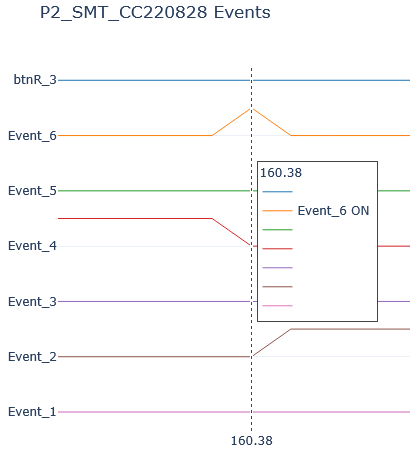

### Case 2: Brief event stays when cleaning channels

Another, perhaps better way, is cleaning channels before summing them into events. However, in the example below, where 001+003 (Even 5) is preceeded by a brief 003, cleaning the channels (by removing fake 003s and single sample triggers), wouldn't do anything as everyhing looks fine. But when summing the channels into events, there would be a brief Event 4 (STI003 is ON), followed by Event 5 (both, 003 and 001 are ON). The Event 4 in this case lasts only one sample and should be excluded. One way is to leave it as is and when finding events with `mne.find_events` set the `min_duration` to `0.002` (two samples). 



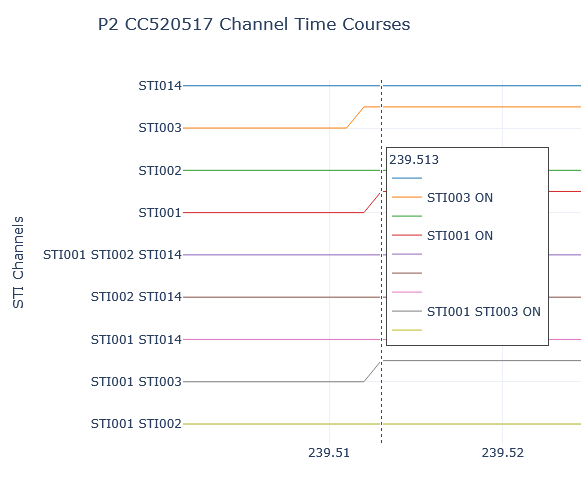



### Case 3: Event 5 becomes Event 1 when removing fake STI003 in channel cleaning


When cleaning the channels, instead of the summed events, in addition to losing some possibly real Events 4, if a 'fake' one interfered with them, I am also losing some Events 5, if STI001 came ON during the 'fake' STI003 - and that creates wrong Event 1 ...

Should I remove all channel activities when removing the fake 003, or remove 003 only until it is ON alone?

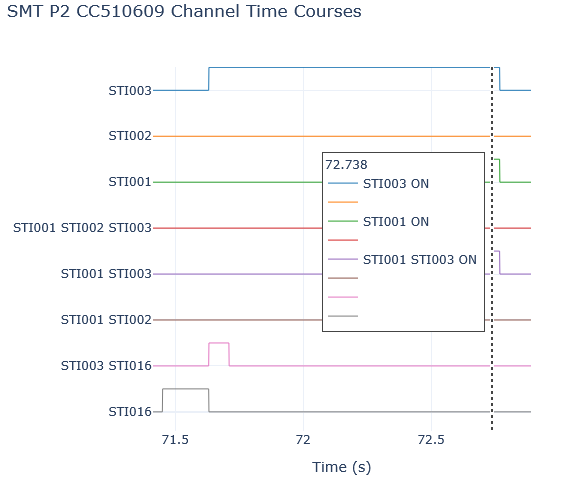

### Solutions

In v6 I am cleaning channels, instead of events, but in a more sophisticated way. 



#### Case 1: Shifted onset when cleaning events

Solved by removing fake STI003 only at timepoints when it doesn't overlap with other events (Step 2 in `clean_sti101_timeseries`). The remaining single sample overlap was removed by Step 3 as short event.  

Unique values found: [1, 2, 3, 4, 5, 6, 16384, 16388]; Individual channels: ['STI001', 'STI002', 'STI003', 'STI015']
Removed STI003 1720 timepoints between 158660-160381 where no other STI001-STI008 channels were active.
Removed STI003 3339 timepoints between 393886-397225 where no other STI001-STI008 channels were active.
Removed STI003 1601 timepoints between 468997-470599 where no other STI001-STI008 channels were active.
Removed short STI003 event at timepoints 160380 to 160381.
Removed short STI003 event at timepoints 470598 to 470599.
Event Counts:
------------------------------------------------
  1    |   2    |   3    |   4    |   5    | 16384 
------------------------------------------------
  40   |   40   |   40   |   4    |   4    |  131  
------------------------------------------------
------------------------------------------------------------
Removing a brief Event 6 and correcting the onset for Event 2
------------------------------------------------------------
Deco

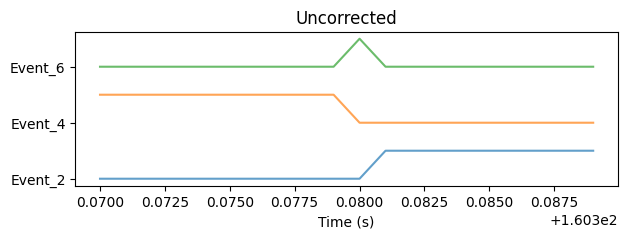

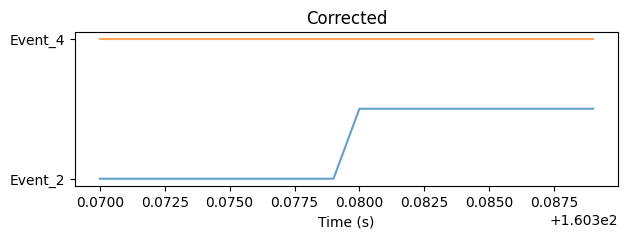

------------------------------------------------------------
Removing a brief Event 5 and correcting the onset for Event 1
------------------------------------------------------------
Decomposed sti101:
[[0 0 4 0]
 [0 0 4 0]
 [0 0 4 0]
 [1 0 4 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]

Uncorrected Event time series:
[[0 0 0 4 0 0 0]
 [0 0 0 4 0 0 0]
 [0 0 0 4 0 0 0]
 [0 0 0 0 5 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]

Cleaned time series:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]


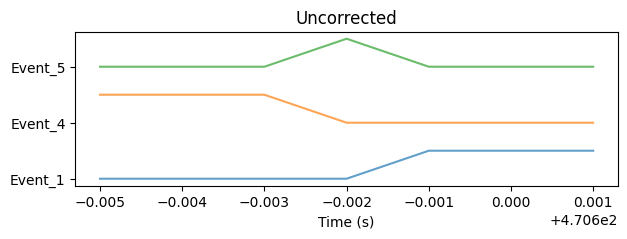

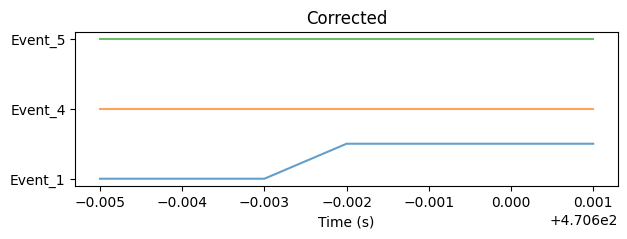

In [61]:
raw_file = "/megdata/camcan/camcan/meg12_0464_cc220828/120920/task_raw.fif"

# Decompose STI101 channel into individual channels
time_series_array, individual_channels, raw = decompose_sti101_in_individual_channels(raw_file=raw_file, verbose=True)
# Translate individual channels to events before correction - for plotting later
uncorrected_event_time_series, uncorrected_event_names = translate_channels_to_events(time_series_array, individual_channels)
# Clean event time series
cleaned_time_series, removed_events = clean_sti101_timeseries(data101=time_series_array, sti_channels=individual_channels, verbose=True)
# Translate individual channels to events after correction - for plotting later
corrected_event_time_series, corrected_event_names = translate_channels_to_events(cleaned_time_series, individual_channels)
# Sum stimulus channels and find events
events, event_counts = sum_stim_channels_and_find_events(cleaned_time_series, individual_channels, raw)
print_event_counts_table(event_counts)

# Cleaned examples

print("-"*60 + "\nRemoving a brief Event 6 and correcting the onset for Event 2\n" + "-"*60)
print(f"Decomposed sti101:\n{time_series_array[160378:160383].astype(int)}")
print(f"\nUncorrected Event time series:\n{uncorrected_event_time_series[160378:160383].astype(int)}")
print(f"\nCleaned time series:\n{cleaned_time_series[160378:160383].astype(int)}")
plt.figure(figsize=(7, 2))
plt = create_basic_plot(uncorrected_event_time_series[160370:160390], raw.times[160370:160390], uncorrected_event_names, show_channels=['Event_4', 'Event_6', 'Event_2'], title='Uncorrected')
plt.show()
plt.figure(figsize=(7, 2))
plt = create_basic_plot(corrected_event_time_series[160370:160390], raw.times[160370:160390], corrected_event_names, show_channels=['Event_4', 'Event_6', 'Event_2'], title='Corrected')
plt.show()

print("-"*60 + "\nRemoving a brief Event 5 and correcting the onset for Event 1\n" + "-"*60)
print(f"Decomposed sti101:\n{time_series_array[470595:470602].astype(int)}")
print(f"\nUncorrected Event time series:\n{uncorrected_event_time_series[470595:470602].astype(int)}")
print(f"\nCleaned time series:\n{cleaned_time_series[470595:470602].astype(int)}")

plt.figure(figsize=(7, 2))
plt = create_basic_plot(uncorrected_event_time_series[470595:470602], raw.times[470595:470602], uncorrected_event_names, show_channels=['Event_4', 'Event_5', 'Event_1'], title='Uncorrected')
plt.show()
plt.figure(figsize=(7, 2))
plt = create_basic_plot(corrected_event_time_series[470595:470602], raw.times[470595:470602], corrected_event_names, show_channels=['Event_4', 'Event_5', 'Event_1'], title='Corrected')
plt.show()

#### Case 2: Removing isolated events

This was solved by Step 4 of the `clean_sti101_timeseries` function - Remove single-channel non-button events if they are immediately followed by a summed non-button event. 

Unique values found: [1, 2, 3, 4, 5, 8192, 8193, 8194, 8195]; Individual channels: ['STI001', 'STI002', 'STI003', 'STI014']
Removed isolated STI003 at timepoint 239512 because a summed event followed.
Event Counts:
------------------------------------------------
  1    |   2    |   3    |   4    |   5    |  8192 
------------------------------------------------
  40   |   40   |   40   |   4    |   4    |  125  
------------------------------------------------
------------------------------------------------------------
Removing isolated Event 4
------------------------------------------------------------
Decomposed sti101:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 4 0]
 [1 0 4 0]
 [1 0 4 0]]

Uncorrected Event time series:
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 4 0 0]
 [0 0 0 0 5 0]
 [0 0 0 0 5 0]]

Cleaned time series:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 0 4 0]
 [1 0 4 0]]


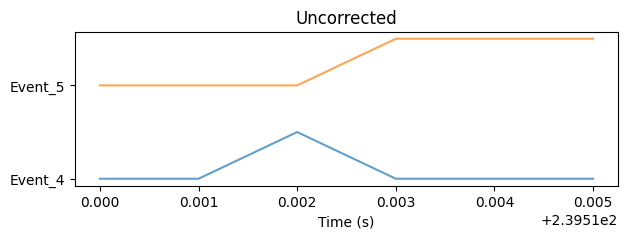

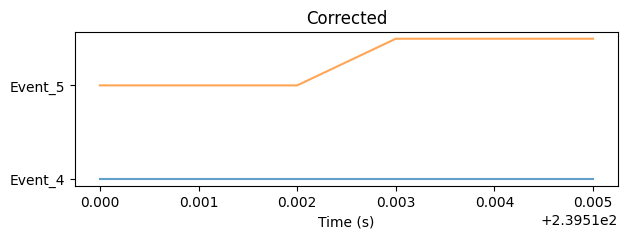

In [62]:
raw_file = "/megdata/camcan/camcan/meg13_0136_cc520517/130319/task_raw.fif"

# Decompose STI101 channel into individual channels
time_series_array, individual_channels, raw = decompose_sti101_in_individual_channels(raw_file=raw_file, verbose=True)
# Translate individual channels to events before correction - for plotting later
uncorrected_event_time_series, uncorrected_event_names = translate_channels_to_events(time_series_array, individual_channels)
# Clean event time series
cleaned_time_series, removed_events = clean_sti101_timeseries(data101=time_series_array, sti_channels=individual_channels, verbose=True)
# Translate individual channels to events after correction - for plotting later
corrected_event_time_series, corrected_event_names = translate_channels_to_events(cleaned_time_series, individual_channels)
# Sum stimulus channels and find events
events, event_counts = sum_stim_channels_and_find_events(cleaned_time_series, individual_channels, raw)
print_event_counts_table(event_counts)

# Cleaned example
print("-"*60 + "\nRemoving isolated Event 4\n" + "-"*60)
print(f"Decomposed sti101:\n{time_series_array[239510:239515].astype(int)}")
print(f"\nUncorrected Event time series:\n{uncorrected_event_time_series[239510:239515].astype(int)}")
print(f"\nCleaned time series:\n{cleaned_time_series[239510:239515].astype(int)}")

plt.figure(figsize=(7, 2))
plt = create_basic_plot(uncorrected_event_time_series[239510:239516], raw.times[239510:239516], uncorrected_event_names, show_channels=['Event_4', 'Event_5'], title='Uncorrected')
plt.show()
plt.figure(figsize=(7, 2))
plt = create_basic_plot(corrected_event_time_series[239510:239516], raw.times[239510:239516], corrected_event_names, show_channels=['Event_4', 'Event_5'], title='Corrected')
plt.show()

#### Case 3: Preserving Event 5 which onsets during presumably fake STI004

This was solved by Step 2 of the `clean_sti101_timeseries` function - Remove STI003 if it started while STI015 or STI016 was active, but only at timepoints where no other STI001-STI008 channels are active. 

In [70]:
raw_file = "/megdata/camcan/camcan/meg12_0080_cc510609/120317/task_raw.fif"

# Decompose STI101 channel into individual channels
time_series_array, individual_channels, raw = decompose_sti101_in_individual_channels(raw_file=raw_file, verbose=True)
# Clean event time series
cleaned_time_series, removed_events = clean_sti101_timeseries(data101=time_series_array, sti_channels=individual_channels, verbose=True)
# Sum the stimulus channels and find events
events, event_counts = sum_stim_channels_and_find_events(cleaned_time_series, individual_channels, raw)
print_event_counts_table(event_counts)

Unique values found: [-32768, -32764, 1, 2, 3, 4, 5, 7]; Individual channels: ['STI001', 'STI002', 'STI003', 'STI016']
STI003 came ON while STI056/016 was on; Removed STI003 872 timepoints between 26482-27355 where no other STI001-STI008 channels were active.
STI003 came ON while STI056/016 was on; Removed STI003 3166 timepoints between 61567-64733 where no other STI001-STI008 channels were active.
STI003 came ON while STI056/016 was on; Removed STI003 1103 timepoints between 71632-72769 where no other STI001-STI008 channels were active.
STI003 came ON while STI056/016 was on; Removed STI003 1673 timepoints between 191785-193458 where no other STI001-STI008 channels were active.
STI003 came ON while STI056/016 was on; Removed STI003 1470 timepoints between 266895-268366 where no other STI001-STI008 channels were active.
STI003 came ON while STI056/016 was on; Removed STI003 3050 timepoints between 437054-440104 where no other STI001-STI008 channels were active.
STI003 came ON while STI

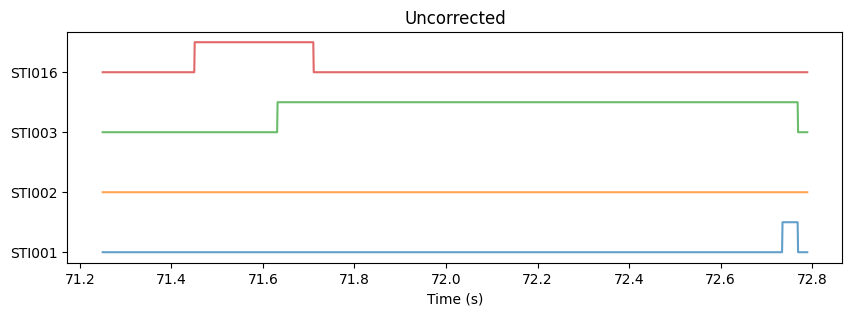

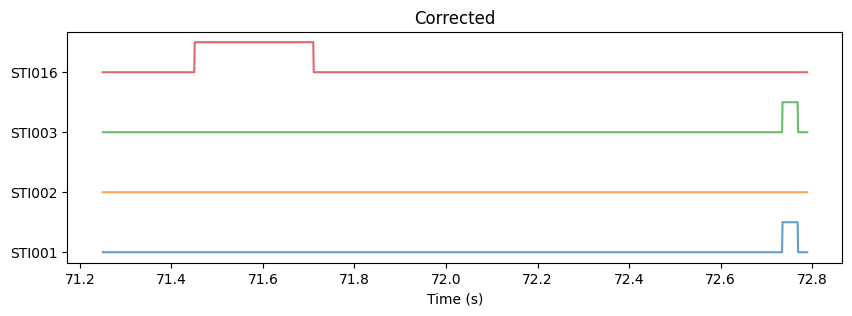


Decomposed sti101:
[[0 0 4 0]
 [0 0 4 0]
 [1 0 4 0]
 [1 0 4 0]
 [1 0 4 0]
 [1 0 4 0]
 [1 0 4 0]]

Cleaned time series:
[[0 0 0 0]
 [0 0 0 0]
 [1 0 4 0]
 [1 0 4 0]
 [1 0 4 0]
 [1 0 4 0]
 [1 0 4 0]]


In [68]:
plt.figure(figsize=(10, 3))
plt = create_basic_plot(time_series_array[71250:72790], raw.times[71250:72790], individual_channels, title="Uncorrected")
plt.show()
plt.figure(figsize=(10, 3))
plt = create_basic_plot(cleaned_time_series[71250:72790], raw.times[71250:72790], individual_channels, title="Corrected")
plt.show()

original = time_series_array[71632:72769].astype(int)
cleaned = cleaned_time_series[71632:72769].astype(int)

print(f"\nDecomposed sti101:\n{time_series_array[72733:72740].astype(int)}")
print(f"\nCleaned time series:\n{cleaned_time_series[72733:72740].astype(int)}")

## Generate Phase/Task HTML Reports 

In [109]:

# -----------------------------------------------------------------------------------------------
# Load all phases
# -----------------------------------------------------------------------------------------------
sessions = {
    # 'P2': ['/imaging/camcan/cc700/CC700_MEG_Times.tsv', '/imaging/camcan/ccfrail/CCFrail_MEG_Times.tsv'],
    # 'P3': ['/imaging/camcan/cc280/CC280_MEG_Times.tsv'],
    'P5': ['/imaging/camcan/ccrescan/CCrescan_MEG_Times.tsv']
}

tasks = ['MMN']

# Load P5 subjects to filter P2 and P3
p5_ccids = set()
for file in sessions['P5']:
    df = pd.read_csv(file, sep='\t')
    p5_ccids.update(df['CCID'].str.lower())

for phase, files in sessions.items():
    
    for task in tasks:
        subjects_data = {}
        phase_ccids = set()
        
        for file in files:
            df = pd.read_csv(file, sep='\t')
            phase_ccids.update(df['CCID'].str.lower())
        
        # Retain only subjects in P5
        phase_ccids &= p5_ccids
        
        phase_data = []
        for file in files:
            df = pd.read_csv(file, sep='\t')
            df['CCID'] = df['CCID'].str.lower()
            phase_data.append(df)
        
        # Process each subject
        for ccid in tqdm(sorted(phase_ccids), desc=f"Processing {phase} {task}", unit="subject"):
            for df in phase_data:
                match = df[df['CCID'] == ccid]
                if not match.empty:
                    subject = match.iloc[0]['CCID'].upper()
                    task_fname = str(match.iloc[0][task]) if task in match.columns and pd.notna(match.iloc[0][task]) else None

                    if task_fname:
                      
                        # Decompose STI101 channel into individual channels
                        output_text_sti, (time_series_array, channel_names, raw) = capture_print_output(decompose_sti101_in_individual_channels, task_fname)
                        
                        # If no STI101 channel, skip the subject
                        if not channel_names:
                            print(f"Skipping {subject} due to no active STI channels in {phase} {task_fname}")
                            break
                                                
                        # Clean event time series
                        output_text_clean, (cleaned_time_series, removed_events) = capture_print_output(clean_sti101_timeseries, data101=time_series_array, sti_channels=channel_names, verbose=True)
                        
                        # Sum the stimulus channels and find events
                        events, event_counts = sum_stim_channels_and_find_events(cleaned_time_series, channel_names, raw)

                        # Print event counts in a table format
                        out_text_table = capture_print_output(print_event_counts_table, event_counts)

                        # Combine outputs
                        output_text = f"File name: {task_fname}\n" + output_text_sti.strip() + "\n" + output_text_clean.strip() + "\n" + out_text_table[0].strip()
                        
                        # Plot the cleaned channels with removed points overlaid
                        plt.figure(figsize=(20, 3))
                        create_removed_event_plot(time_series_array, raw.times, channel_names, removed_events, y_offset=2, title="Individual Channel Time Courses")

                        # Convert plot to base64 image
                        img_buffer = BytesIO()
                        plt.savefig(img_buffer, format='png', bbox_inches='tight')
                        plt.close()
                        img_data = base64.b64encode(img_buffer.getvalue()).decode()
                        subjects_data[subject] = (task_fname, output_text, img_data)
                    break
        
        if subjects_data:
          # Generate HTML report
          output_html_path = f"/imaging/correia/da05/projects/dc_camcan/reports/Report_MEG_{phase}_{task}_Channel_Triggers_v6.html"
          generate_html_report(subjects_data, phase, task, output_html_path, title="MEG Channel Triggers")
          print(f"Report generated: {output_html_path}")

Processing P5 MMN:  24%|██▍       | 32/133 [01:22<03:12,  1.90s/subject]

Skipping CC310473 due to no active STI channels in P5 /megdata/camcan/camcan_rescan/meg23_158_cc310473/230531/mmn_raw.fif


Processing P5 MMN:  38%|███▊      | 50/133 [02:39<04:25,  3.20s/subject]

Skipping CC410101 due to no active STI channels in P5 /megdata/camcan/camcan_rescan/meg24_090_cc410101/240326/mmn_raw.fif


Processing P5 MMN: 100%|██████████| 133/133 [10:30<00:00,  4.74s/subject]

Report generated: /imaging/correia/da05/projects/dc_camcan/reports/Report_MEG_P5_MMN_Channel_Triggers_v6.html


#### Event Plots for subjects to check

In [ ]:
raw_file_paths = {
  # "P2_SMT_CC310473": "/megdata/camcan/camcan/meg12_0232_cc310473/120525/task_raw.fif",
  # "P2_SMT_CC410129": "/megdata/camcan/camcan/meg11_0170_cc410129/110623/task_raw.fif",
  # "P2_SMT_CC420396": "/megdata/camcan/camcan/meg13_0253_cc420396/130518/task_raw.fif",
  # "P2_SMT_CC510609": "/megdata/camcan/camcan/meg12_0080_cc510609/120317/task_raw.fif",
  # "P2_SMT_CC520065": "/megdata/camcan/camcan/meg12_0197_cc520065/120512/task_raw.fif",
  # "P2_SMT_CC520480": "/megdata/camcan/camcan/meg13_0161_cc520480/130405/task_raw.fif",
  # "P2_SMT_CC620193": "/megdata/camcan/camcan/meg12_0400_cc620193/120813/task_raw.fif",
  # "P2_SMT_CC320022": "/megdata/camcan/camcan/meg12_0246_cc320022/120607/task_raw.fif",
  # "P2_SMT_CC510256": "/megdata/camcan/camcan/meg11_0185_cc510256/110716/task_raw.fif",
  # "P2_SMT_CC410182": "/megdata/camcan/camcan/meg11_0187_cc410182/110719/task_raw.fif",
  # "P2_SMT_CC220828": "/megdata/camcan/camcan/meg12_0464_cc220828/120920/task_raw.fif", # used STI015 and had long events 4
  # "P2_SMT_CC320218": "/megdata/camcan/camcan/meg12_0322_cc320218/120713/task_raw.fif", # event 4 at the very start
  # "P2_SMT_CC420231": "/megdata/camcan/camcan/meg12_0540_cc420231/121123/task_raw.fif", # lost one seemingly genuine event 4 as it started while a button was pressed
}

for subject, raw_file in raw_file_paths.items():
  
  # Decompose STI101 channel into individual channels
  time_series_array, individual_channels, raw = decompose_sti101_in_individual_channels(raw_file, verbose=False)

  # Translate individual channels to events
  event_time_series, event_names = translate_channels_to_events(time_series_array, individual_channels)

  # Create interactive plot of the event time series
  fig = create_interactive_plot(event_time_series, raw.times, event_names, title=f"{subject} Events", hovermode="x unified")
  fig.write_html(f"/imaging/correia/da05/projects/dc_camcan/reports/event_plots/events_{subject}_plot.html")

### Uncorrected

In [89]:

# -----------------------------------------------------------------------------------------------
# Load all phases
# -----------------------------------------------------------------------------------------------
sessions = {
    'P3': ['/imaging/camcan/cc280/CC280_MEG_Times.tsv'], # Rest, Pic Name, Syn Task1, Syn Task2, Word Recog, MMN, Scene Rep, SNG1, SNG2
    'P5': ['/imaging/camcan/ccrescan/CCrescan_MEG_Times.tsv'] # Rest, Passice, SMT, MMN, SNG, Movie, Story
}

tasks = ['SNG2']

# Load P5 subjects to filter P2 and P3
p5_ccids = set()
for file in sessions['P5']:
    df = pd.read_csv(file, sep='\t')
    p5_ccids.update(df['CCID'].str.lower())

for phase, files in sessions.items():
    
    for task in tasks:
        subjects_data = {}
        phase_ccids = set()
        
        for file in files:
            df = pd.read_csv(file, sep='\t')
            phase_ccids.update(df['CCID'].str.lower())
        
        # Retain only subjects in P5
        phase_ccids &= p5_ccids
        
        phase_data = []
        for file in files:
            df = pd.read_csv(file, sep='\t')
            df['CCID'] = df['CCID'].str.lower()
            phase_data.append(df)
        
        # Process each subject
        for ccid in tqdm(sorted(phase_ccids), desc=f"Processing {phase} {task}", unit="subject"):
            for df in phase_data:
                match = df[df['CCID'] == ccid]
                if not match.empty:
                    subject = match.iloc[0]['CCID'].upper()
                    task_fname = str(match.iloc[0][task]) if task in match.columns and pd.notna(match.iloc[0][task]) else None

                    if task_fname:
                        # Decompose STI101 channel into individual channels
                        output_text_sti, (time_series_array, channel_names, raw) = capture_print_output(decompose_sti101_in_individual_channels, task_fname)
                        
                        # Translate individual channels to events
                        event_time_series, event_names = translate_channels_to_events(time_series_array, channel_names)
                        
                        # # Clean event time series
                        # output_text_clean, (cleaned_time_series, removed_events) = capture_print_output(clean_event_timeseries, event_time_series, event_names, min_event_duration=0.002, max_event_duration=0.3, sampling_rate=raw.info['sfreq'], verbose=True)
                        
                        # Create corrected events
                        events, event_counts = create_event_onsets(event_time_series.T, event_names, raw, verbose=False)

                        # Print event counts in a table format
                        out_text_table = capture_print_output(print_event_counts_table, event_counts)

                        # Combine outputs
                        output_text = f"File name: {task_fname}\n" + output_text_sti.strip() + "\n" + "\n" + out_text_table[0].strip()
                        
                        # # Plot the un-cleaned events with removed events overlaid
                        # plt.figure(figsize=(20, 3))
                        # create_removed_event_plot(event_time_series, raw.times, event_names, removed_events, y_offset=2, title="Event Time Courses")
                        
                        # Basic plot of the event time series
                        plt.figure(figsize=(20, 3))
                        create_basic_plot(event_time_series, raw.times, event_names, title=f"{subject} Events")

                        # Convert plot to base64 image
                        img_buffer = BytesIO()
                        plt.savefig(img_buffer, format='png', bbox_inches='tight')
                        plt.close()
                        img_data = base64.b64encode(img_buffer.getvalue()).decode()
                        subjects_data[subject] = (task_fname, output_text, img_data)
                    break
                  
        if subjects_data:
          # Generate HTML report
          output_html_path = f"/imaging/correia/da05/projects/dc_camcan/reports/Report_MEG_{phase}_{task}_Event_Triggers_uncorrected.html"
          generate_html_report(subjects_data, phase, task, output_html_path)
          print(f"Report generated: {output_html_path}")

Processing P3 SNG2:   0%|          | 0/66 [00:00<?, ?subject/s]

Processing P3 SNG2: 100%|██████████| 66/66 [03:05<00:00,  2.80s/subject]


Report generated: /imaging/correia/da05/projects/dc_camcan/reports/Report_MEG_P3_SNG2_Event_Triggers_uncorrected.html


Processing P5 SNG2: 100%|██████████| 133/133 [00:00<00:00, 4976.78subject/s]


## Plotting

In [42]:
# Original channels and additional from STI101
data, times, channel_lables = get_channel_timecourses('/megdata/camcan/camcan/meg12_0322_cc320218/120713/task_raw.fif')

# fig = create_interactive_plot(data, times, channel_lables, show_channels=['STI002', 'STI003', 'STI002 STI003'], title="Channel Time Courses")
fig = create_interactive_plot(data, times, channel_lables, title="P2 CC320218/ Channel Time Courses")
fig.write_html(f"/imaging/correia/da05/projects/dc_camcan/SMT_P2_CC320218_channels_plot.html")



Getting active channel timecourses...
Original channels: ['STI001', 'STI002', 'STI003', 'STI004', 'STI005', 'STI006', 'STI007', 'STI008', 'STI009', 'STI010', 'STI011', 'STI012', 'STI013', 'STI014']
Kept active Channels: ['STI001', 'STI002', 'STI003']
Removed Channels: ['STI004', 'STI005', 'STI006', 'STI007', 'STI008', 'STI009', 'STI010', 'STI011', 'STI012', 'STI013', 'STI014']
Unique values in STI101: [-32768, -32764, 1, 2, 3, 4, 5, 6]
Decoded STI101 values: ['STI016', 'STI003 STI016', 'STI001', 'STI002', 'STI001 STI002', 'STI003', 'STI001 STI003', 'STI002 STI003']
Kept STI101 Channels: ['STI016', 'STI003 STI016', 'STI001 STI002', 'STI001 STI003', 'STI002 STI003']
Final channel labels: ['STI016', 'STI003 STI016', 'STI001 STI002', 'STI001 STI003', 'STI002 STI003', 'STI001', 'STI002', 'STI003']


In [112]:
# Individual channels from STI101
time_series_array, individual_channels, raw = decompose_sti101_in_individual_channels(raw_file='/megdata/camcan/camcan_rescan/meg23_334_cc420094/230905/sng_raw.fif')
subject = 'CC420094'
fig101 = create_interactive_plot(time_series_array, raw.times, individual_channels, title=f"{subject} Channel Time Courses")
fig101.write_html(f"/imaging/correia/da05/projects/dc_camcan/SNG_P5_{subject}_individual_channels_plot.html")


Unique values found: [-32768, -32767, -32766, -32764, -32763, -32760, -28672, -28671, -28665, 1, 2, 3, 4, 5, 6, 7, 8, 32, 4096, 4103, 4112, 8192, 8200, 8224, 8232, 12288]; Individual channels: ['STI001', 'STI002', 'STI003', 'STI004', 'STI005', 'STI006', 'STI013', 'STI014', 'STI016']


## Simulating BIDS Event File Output

In [ ]:
sample_events = np.array([[0,4,4,4,6,2,2,2,0]])  

info = mne.create_info(['test101'], sfreq=1000, ch_types=['stim'])
raw_temp = mne.io.RawArray(sample_events, info)

# Add a fake MEG channel (necessary for BIDS)
meg_data = np.zeros((1, sample_events.shape[1]))  # Fake MEG channel with zeros
meg_info = mne.create_info(['MEG 001'], sfreq=1000, ch_types=['mag'])  # Magnetometer
raw_meg = mne.io.RawArray(meg_data, meg_info)

# Merge the MEG and stimulus data
raw_temp.add_channels([raw_meg], force_update_info=True)

# Find events
consecutive = 'increasing'

events = mne.find_events(
    raw_temp, 
    stim_channel='test101',  
    #shortest_event=1,
    min_duration=0.002,
    consecutive=consecutive
)

# Convert events to a DataFrame
events_df = pd.DataFrame(events, columns=['onset', 'preceeding_value', 'event_code'])
print(events_df)

# Correct `event_id` dictionary (descriptive names as keys, event codes as values)
event_id = {
    'audiovis/600Hz': 2,
    'audiovis/600Hz+catch/audio': 6,
    'catch/audio': 4
}

# Set up BIDS path
bids_path = BIDSPath(
    subject="test",
    task="test",
    root=f"/imaging/correia/da05/projects/dc_camcan/BIDS_events_test/{consecutive}",
    datatype="meg"
)

# Write to BIDS
write_raw_bids(
    raw=raw_temp,
    bids_path=bids_path,
    events=events,
    event_id=event_id,
    allow_preload=True,
    format='FIF',
    overwrite = True
)

print("\nSample Events")
times = (raw_temp.times * 1000).astype(int) 

sample_df = pd.DataFrame(
    np.column_stack((times, sample_events.T)), 
    columns=['time', 'sti101']  
)
print(sample_df.to_string(index=False))

print("\nMNE Detected Events:")
events_df = pd.DataFrame(events, columns=['onset', 'preceeding_value', 'event_code'])
print(events_df.to_string(index=False))

df = pd.read_csv("/imaging/correia/da05/projects/dc_camcan/BIDS_events_test/increasing/sub-test/meg/sub-test_task-test_events.tsv", sep='\t') 
print("\nMNE BIDS events:")
print(df.to_string(index=False))

Creating RawArray with float64 data, n_channels=1, n_times=9
    Range : 0 ... 8 =      0.000 ...     0.008 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=9
    Range : 0 ... 8 =      0.000 ...     0.008 secs
Ready.
1 event found on stim channel test101
Event IDs: [4]
   onset  preceeding_value  event_code
0      1                 0           4
Writing '/imaging/correia/da05/projects/dc_camcan/BIDS_events_test/increasing/participants.tsv'...
Writing '/imaging/correia/da05/projects/dc_camcan/BIDS_events_test/increasing/participants.json'...
Writing '/imaging/correia/da05/projects/dc_camcan/BIDS_events_test/increasing/sub-test/meg/sub-test_coordsystem.json'...
Writing '/imaging/correia/da05/projects/dc_camcan/BIDS_events_test/increasing/sub-test/meg/sub-test_coordsystem.json'...
Used Annotations descriptions: ['catch/audio']
Writing '/imaging/correia/da05/projects/dc_camcan/BIDS_events_test/increasing/sub-test/meg/sub-test_task-test_events.tsv'...
Writing '/imagin

## Old Reports

In [ ]:
raw_file_paths = {
    'normal cc410091-P2': '/megdata/camcan/camcan/meg11_0111_cc410091/110504/task_raw.fif', # normal
    'problematic cc610051-P2': '/megdata/camcan/camcan/meg11_0326_cc610051/111216/task_raw.fif', # problematic (too many events 4 and some combined events)
    # 'crazy cc620193-P5': '/megdata/camcan/camcan_rescan/meg23_299_cc620193/230814/task_raw.fif', # crazy subject
    # 'Maite''s discovered cc720103-P2': '/megdata/camcan/camcan/meg13_0134_cc720103/130319/task_raw.fif', # Maite's discovered problematic
}

verbose  = True

for subject, raw_file in raw_file_paths.items():
    print('='*100)
    print(f"Subject: {subject} {raw_file}")
    print('='*100)
    
    print('-'*30 + "\nOriginal events from MNE\n" + '-'*30)
    original_events = get_original_events(raw_file, verbose=verbose)
    
    print('-'*30 + "\nMy corrected events\n" + '-'*30)
    time_series_array, channel_names, raw = decompose_sti101_in_individual_channels(raw_file)
    my_events, _ = create_event_onsets(time_series_array, channel_names, raw, verbose=verbose)
   
    print('-'*30 + "\nRik's corrected events\n" + '-'*30)
    rik_events = get_corrected_event_onsets(raw_file, channel='STI101', verbose=verbose)
    
    print(f"\nMy events same as MNE's: {np.all(my_events[:, [0, 2]] == original_events[:, [0, 2]])}")
    print(f"My events same as Rik's: {np.all(my_events[:, [0, 2]] == rik_events[:, [0, 1]])}")
    
    

In [ ]:
raw_file_paths = {
  'cc720718 P5': '/megdata/camcan/camcan_rescan/meg23_247_cc720718/230713/task_raw.fif',
  'cc620918 P5': '/megdata/camcan/camcan_rescan/meg24_027_cc620918/240125/task_raw.fif',
  'cc120470 P5': '/megdata/camcan/camcan_rescan/meg24_095_cc120470/240402/task_raw.fif'
}
for subject, raw_file in raw_file_paths.items():
    print('='*100)
    print(f"Subject: {subject} {raw_file}")
    print('='*100)
    
    print('-'*30 + "\nOriginal events from MNE\n" + '-'*30)
    print_original_events(raw_file)
    
    print('-'*30 + "\nCorrected events\n" + '-'*30)
    time_series_array, channel_names, raw = decompose_sti101_in_individual_channels(raw_file)
    create_event_onsets(time_series_array, channel_names, raw)

In [ ]:
# raw_file_paths = {
#   'cc720718 P5': '/megdata/camcan/camcan_rescan/meg23_247_cc720718/230713/task_raw.fif',
#   'cc620918 P5': '/megdata/camcan/camcan_rescan/meg24_027_cc620918/240125/task_raw.fif',
#   'cc120470 P5': '/megdata/camcan/camcan_rescan/meg24_095_cc120470/240402/task_raw.fif'
# }

# for subject, raw_file in raw_file_paths.items():
#   data, times, sti_channels = split_sti101(raw_file=raw_file, data=None, times=None)
#   fig = create_interactive_plot(data, times, sti_channels, downsampling_factor=None, title=f"{subject} STI101 Channel Time Courses")
#   fig.write_html(f"/imaging/correia/da05/projects/dc_camcan/STI101_{subject}_plot_downsampling-None.html")

## Misc

In [ ]:
# -----------------------------------------------------------------------------------------------
  # Plotting the time courses
  # -----------------------------------------------------------------------------------------------
  # data, times, channel_lables = get_channel_timecourses(raw_file)
  
  # plt.figure(figsize=(20, 10))
  # # basic_plot = create_basic_plot(data, times, channel_lables, show_channels=['STI016', 'STI003 STI016', 'STI003'], title=f"{subject} Channel Time Courses")
  # basic_plot = create_basic_plot(data, times, channel_lables, title=f"{subject} Channel Time Courses")
  # basic_plot.show()
  
  # downsampling_factor = None
  # #fig = create_interactive_plot(data, times, channel_lables, show_channels=['STI016', 'STI003 STI016', 'STI003'], downsampling_factor=downsampling_factor, title=f"{subject} Channel Time Courses")
  # fig = create_interactive_plot(data, times, channel_lables, downsampling_factor=downsampling_factor, title=f"{subject} Channel Time Courses")
  
  # save_figure_path = f"/imaging/correia/da05/projects/dc_camcan/{subject}_channels_plot_downsampling-{downsampling_factor}.html"
  
  # if os.path.exists(save_figure_path):
  #   try:
  #     print(f"Removing existing file: {save_figure_path}")
  #     os.remove(save_figure_path)
  #   except:
  #     pass
      
  # fig.write_html(save_figure_path)
  # print(f"Interactive plot saved to: {save_figure_path}")

In [ ]:
# raw_file ='/megdata/camcan/camcan_rescan/meg23_299_cc620193/230814/task_raw.fif'
# data, times, sti_channels = split_sti101(raw_file=raw_file, data=None, times=None)
# # fig = create_interactive_plot(data, times, sti_channels, downsampling_factor=None, title="Scc620193-P5 TI101 Channels Time Course")
# # fig.write_html("/imaging/correia/da05/projects/dc_camcan/STI101_cc620193-P5_plot_downsampling-None.html")
# create_basic_plot(data, times, sti_channels, show_channels=None, title="STI101 Channels Time Course")

In [44]:
raw_file = "/megdata/camcan/camcan_rescan/meg23_150_cc410091/230516/story_raw.fif"

# Decompose STI101 channel into individual channels
time_series_array, individual_channels, raw = decompose_sti101_in_individual_channels(raw_file=raw_file, verbose=True)
# Clean event time series
cleaned_time_series, removed_events = clean_sti101_timeseries(data101=time_series_array, sti_channels=individual_channels, steps=[], verbose=True)
# Sum the stimulus channels and find events
events, event_counts = sum_stim_channels_and_find_events(cleaned_time_series, individual_channels, raw, min_duration=0)
print_event_counts_table(event_counts)

Unique values found: [2, 3, 4]; Individual channels: ['STI001', 'STI002', 'STI003']
Event Counts:
------------------------
  2    |   3    |   4   
------------------------
  1    |   1    |   1   
------------------------


In [ ]:
raw_file = "/megdata/camcan/camcan_rescan/meg23_150_cc410091/230516/story_raw.fif"
raw = mne.io.read_raw_fif(raw_file, preload=True, verbose=True)
raw.annotations.delete(0, raw.annotations.duration)  # Remove all annotations

Opening raw data file /megdata/camcan/camcan_rescan/meg23_150_cc410091/230516/story_raw.fif...
    Read a total of 12 projection items:
        generated with dossp-2.1.2 (1 x 306)  idle
        generated with dossp-2.1.2 (1 x 306)  idle
        generated with dossp-2.1.2 (1 x 306)  idle
        generated with dossp-2.1.2 (1 x 306)  idle
        generated with dossp-2.1.2 (1 x 306)  idle
        generated with dossp-2.1.2 (1 x 306)  idle
        generated with dossp-2.1.2 (1 x 306)  idle
        generated with dossp-2.1.2 (1 x 306)  idle
        generated with dossp-2.1.2 (1 x 306)  idle
        generated with dossp-2.1.2 (1 x 306)  idle
        generated with dossp-2.1.2 (1 x 306)  idle
        generated with dossp-2.1.2 (1 x 306)  idle
    Range : 22000 ... 395999 =     22.000 ...   395.999 secs
Ready.
Reading 0 ... 373999  =      0.000 ...   373.999 secs...


<Annotations | 0 segments>

## Test auditory and visual delays for the dates of acquisition

In [ ]:
def get_delays_for_fif(raw_file, delay_auditory_df, delay_visual_df):
    raw = mne.io.read_raw_fif(raw_file, preload=False, verbose=False)
    meas_date = raw.info['meas_date'].replace(tzinfo=None)  # remove timezone if present

    matched_auditory_delay = delay_auditory_df[delay_auditory_df['Date'] <= meas_date]
    if matched_auditory_delay.empty:
        raise ValueError(f"No auditory delay found for measurement date: {meas_date}")
      
    matched_visual_delay = delay_visual_df[delay_visual_df['Date'] <= meas_date]
    if matched_visual_delay.empty:
        raise ValueError(f"No visual delay found for measurement date: {meas_date}")
    
    auditory_delay_ms = matched_auditory_delay.iloc[-1]['Mean Delay Rounded (ms)']
    visual_delay_ms = matched_visual_delay.iloc[-1]['Mean Delay Rounded (ms)']
    
    sfreq = raw.info['sfreq']
    auditory_delay_samples = int(round(auditory_delay_ms * sfreq / 1000))
    visual_delay_samples = int(round(visual_delay_ms * sfreq / 1000))
    
    auditory_visual_delay_samples = int(round((auditory_delay_samples + visual_delay_samples) / 2))
    
    return meas_date, auditory_delay_samples, visual_delay_samples, auditory_visual_delay_samples


# -----------------------------------------------------------------------------
# Load the delays
# -----------------------------------------------------------------------------
auditory_delay_file = '/imaging/camcan/sandbox/da05/ccrescan_meg/auditory_delay.csv'
auditory_delay_df = pd.read_csv(auditory_delay_file)
auditory_delay_df['Date'] = pd.to_datetime(auditory_delay_df['Date'], dayfirst=True)
auditory_delay_df = auditory_delay_df.sort_values('Date')


visual_delay_file = '/imaging/camcan/sandbox/da05/ccrescan_meg/visual_delay.csv'
visual_delay_df = pd.read_csv(visual_delay_file)
visual_delay_df['Date'] = pd.to_datetime(visual_delay_df['Date'], dayfirst=True)
visual_delay_df = visual_delay_df.sort_values('Date')


In [6]:

# -----------------------------------------------------------------------------
# Get delays for all dates when Rest was acquired
# -----------------------------------------------------------------------------

sessions = {
    'P2': ['/imaging/camcan/cc700/CC700_MEG_Times.tsv', '/imaging/camcan/ccfrail/CCFrail_MEG_Times.tsv'],
    'P3': ['/imaging/camcan/cc280/CC280_MEG_Times.tsv'],
    'P5': ['/imaging/camcan/ccrescan/CCrescan_MEG_Times.tsv']
}

tasks = ['Rest']

# Load P5 subjects to filter P2 and P3
p5_ccids = set()
for file in sessions['P5']:
    df = pd.read_csv(file, sep='\t')
    p5_ccids.update(df['CCID'].str.lower())

for phase, files in sessions.items():
    
    for task in tasks:
        subjects_data = {}
        phase_ccids = set()
        
        for file in files:
            df = pd.read_csv(file, sep='\t')
            phase_ccids.update(df['CCID'].str.lower())
        
        # Retain only subjects in P5
        phase_ccids &= p5_ccids
        
        phase_data = []
        for file in files:
            df = pd.read_csv(file, sep='\t')
            df['CCID'] = df['CCID'].str.lower()
            phase_data.append(df)
        
        # Process each subject
        for ccid in sorted(phase_ccids):
            for df in phase_data:
                match = df[df['CCID'] == ccid]
                if not match.empty:
                    subject = match.iloc[0]['CCID'].upper()
                    task_fname = str(match.iloc[0][task]) if task in match.columns and pd.notna(match.iloc[0][task]) else None

                    if task_fname:
                      meas_date, auditory_delay_samples, visual_delay_samples, audio_visual_delay_samples = get_delays_for_fif(task_fname, auditory_delay_df, visual_delay_df)
                      print(f"{phase} {subject} {meas_date} {auditory_delay_samples} {visual_delay_samples} {audio_visual_delay_samples}")
                    else:
                      print(f"{phase} {subject} {task} not found")
                    break

P2 CC120049 2012-10-23 18:29:15.616592 32 34 33
P2 CC120065 2012-07-11 18:37:52.450196 32 34 33
P2 CC120218 2012-03-16 11:31:16.097052 32 34 33
P2 CC120470 2013-07-09 12:02:21.375052 32 34 33
P2 CC120640 2013-08-08 15:04:58.267184 32 34 33
P2 CC120795 2012-10-15 11:34:03.466628 32 34 33
P2 CC121428 2013-06-06 15:42:50.568148 32 34 33
P2 CC210023 2012-02-28 16:57:47.146327 32 34 33
P2 CC210088 2011-05-24 15:17:51.013055 13 34 24
P2 CC220107 2012-07-14 12:50:35.959946 32 34 33
P2 CC220335 2012-07-14 15:35:24.899823 32 34 33
P2 CC220419 2012-07-03 18:09:57.130763 32 34 33
P2 CC220518 2012-12-08 11:36:48.367335 32 34 33
P2 CC220519 2013-03-07 19:13:25.087946 32 34 33
P2 CC220828 2012-09-20 11:49:39.810986 32 34 33
P2 CC220974 2012-11-22 19:13:18.507041 32 34 33
P2 CC221002 2012-11-12 16:20:12.276879 32 34 33
P2 CC221487 2013-06-14 18:09:32.858876 32 34 33
P2 CC221585 2012-12-04 19:31:32.957396 32 34 33
P2 CC221977 2013-05-04 13:08:36.565078 32 34 33
P2 CC222258 2013-01-29 19:22:43.667079 3

## Test Other MEG datasets

In [26]:
# # ls -ld --time-style=long-iso --sort=time /megdata/cbu/*

dir = '/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/'
files = []
for root, dirs, fs in os.walk(dir):
    for f in fs:
        if f.endswith('.fif'):
            files.append(os.path.join(root, f))

files.sort()
files

['/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/mmn_raw.fif',
 '/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/movie_raw.fif',
 '/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/passive_raw.fif',
 '/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/rest_raw.fif',
 '/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/sng_raw.fif',
 '/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/story_raw.fif',
 '/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/task_raw.fif']

In [ ]:
# dir = '/megdata/cbu/fake_diamond'
# # find all .fif files in the directory, excluding 'emptyroom' files
# files = []
# for root, dirs, fs in os.walk(dir):
#     for f in fs:
#         if f.endswith('run1_raw.fif'):
#             files.append(os.path.join(root, f))

# files.sort()
# files


In [36]:
for raw_file in files:
  used_sti_channels = get_used_sti_channels(raw_file)
  print(f"{raw_file}: {used_sti_channels}")
  

/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/mmn_raw.fif: ['STI003', 'STI101']
/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/movie_raw.fif: []
/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/passive_raw.fif: ['STI001', 'STI002', 'STI003', 'STI004', 'STI101']
/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/rest_raw.fif: []
/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/sng_raw.fif: ['STI001', 'STI002', 'STI003', 'STI004', 'STI005', 'STI006', 'STI101']
/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/story_raw.fif: []
/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/task_raw.fif: ['STI001', 'STI002', 'STI003', 'STI101']


In [35]:
for raw_file in files:
  unique_values = get_sti101_values(raw_file)
  print(f"{raw_file}: {unique_values}")


/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/mmn_raw.fif: [4]
/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/movie_raw.fif: [0]
/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/passive_raw.fif: [0 6 7 8 9]
/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/rest_raw.fif: [0]
/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/sng_raw.fif: [   0    1    2    3    4    5    6    7    8   16   32 4096 4103 4112
 8192 8224]
/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/story_raw.fif: [0]
/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/task_raw.fif: [   0    1    2    3    4    5 4096]


/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/mmn_raw.fif
Unique values found: [4]; Individual channels: ['STI003']
Event Counts:







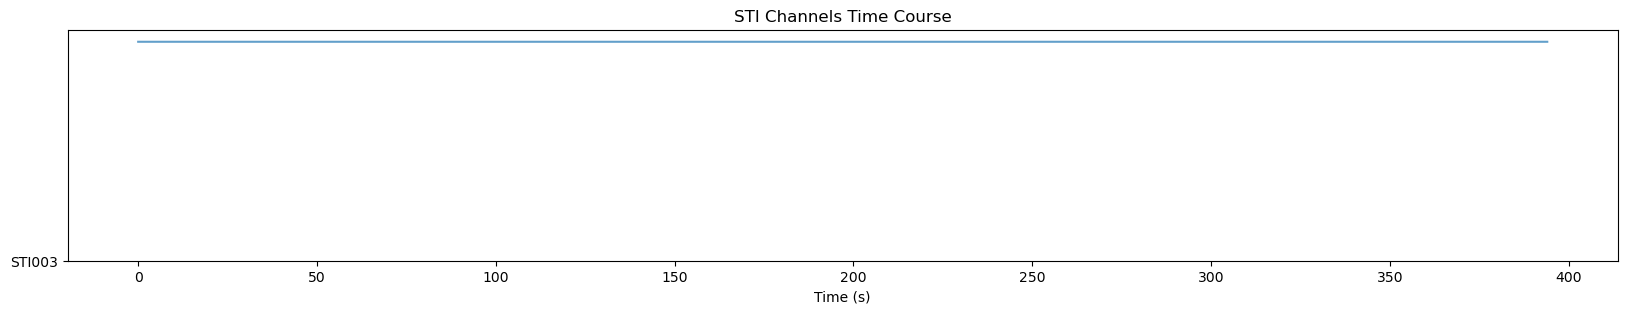

/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/movie_raw.fif
No STI channels used in /megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/movie_raw.fif
/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/passive_raw.fif
Unique values found: [6, 7, 8, 9]; Individual channels: ['STI001', 'STI002', 'STI003', 'STI004']
Event Counts:
--------------------------------
  6    |   7    |   8    |   9   
--------------------------------
  20   |   20   |   20   |   60  
--------------------------------


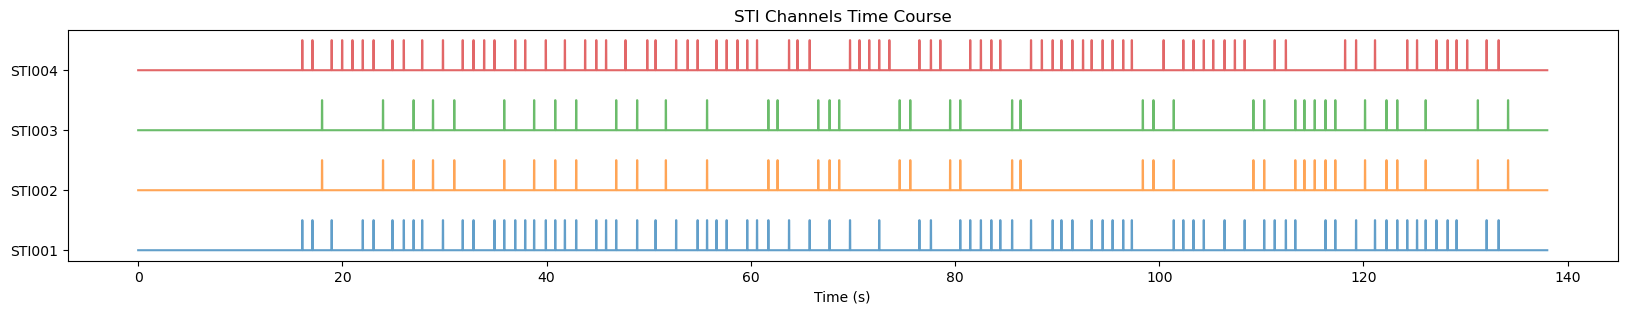

/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/rest_raw.fif
No STI channels used in /megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/rest_raw.fif
/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/sng_raw.fif
Unique values found: [1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 4096, 4103, 4112, 8192, 8224]; Individual channels: ['STI001', 'STI002', 'STI003', 'STI004', 'STI005', 'STI006', 'STI013', 'STI014']
Event Counts:
------------------------------------------------------------------------------------------------
  1    |   2    |   3    |   4    |   5    |   6    |   7    |   8    |   16   |   32   |  4096  |  8192 
------------------------------------------------------------------------------------------------
  83   |   77   |   5    |   15   |   17   |   23   |   17   |   23   |  237   |  226   |   92   |   85  
------------------------------------------------------------------------------------------------


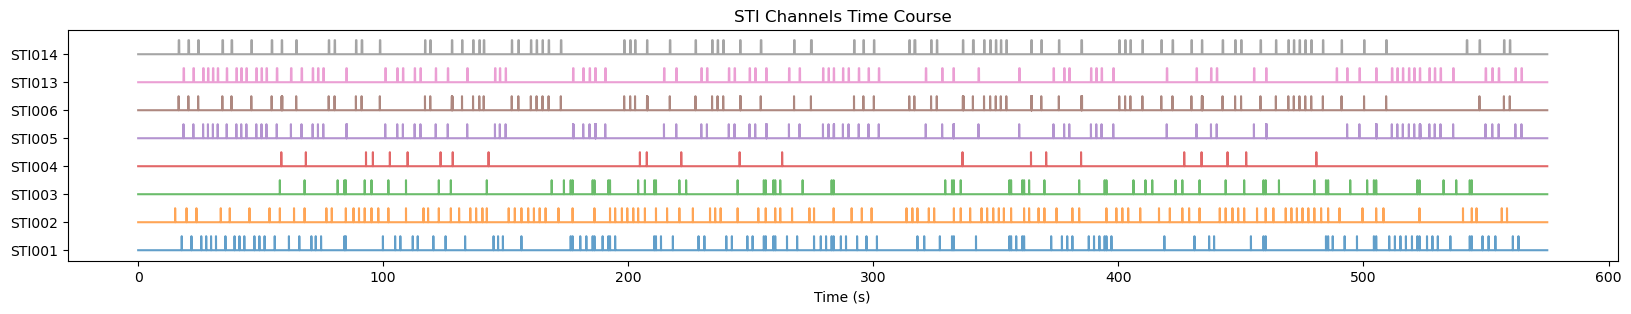

/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/story_raw.fif
No STI channels used in /megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/story_raw.fif
/megdata/camcan/camcan_rescan/meg25_371_cc420173/251106/task_raw.fif
Unique values found: [1, 2, 3, 4, 5, 4096]; Individual channels: ['STI001', 'STI002', 'STI003', 'STI013']
Event Counts:
------------------------------------------------
  1    |   2    |   3    |   4    |   5    |  4096 
------------------------------------------------
  40   |   40   |   40   |   4    |   4    |  121  
------------------------------------------------


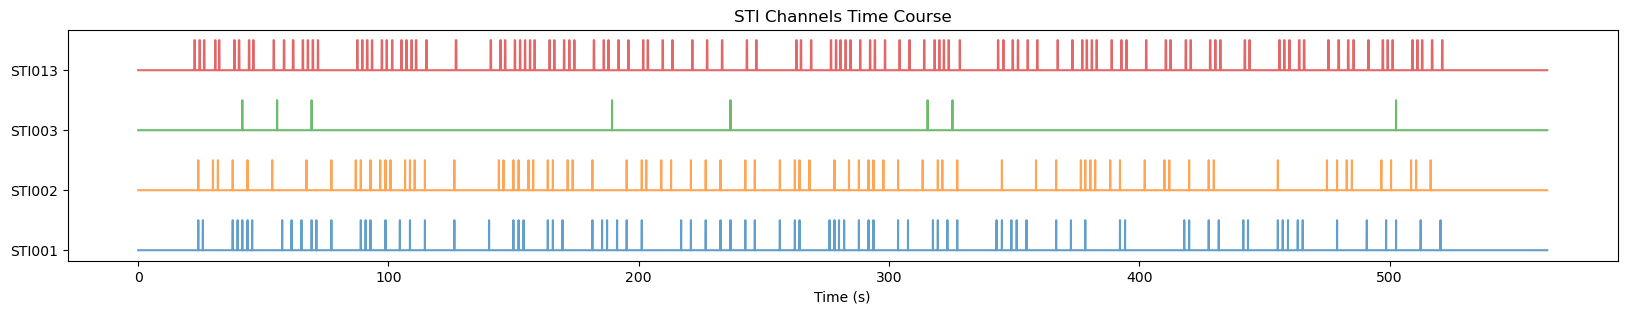

In [37]:
for raw_file in files:
  print('='*100)
  
  print(raw_file)
  # check if any STI channels are used
  used_sti_channels = get_used_sti_channels(raw_file)
  #print(f"{raw_file}: {used_sti_channels}")

  if used_sti_channels:
    time_series_array, individual_channels, raw = decompose_sti101_in_individual_channels(raw_file=raw_file, verbose=True)
    events, event_counts = sum_stim_channels_and_find_events(time_series_array, individual_channels, raw)
    print_event_counts_table(event_counts)
    plt.figure(figsize=(20, 3))
    plt = create_basic_plot(time_series_array, raw.times, individual_channels, show_channels=None, title="STI Channels Time Course")
    plt.show()
  else:
    print(f"No STI channels used in {raw_file}")
